# บทที่ 3a - การประเมินผลโมเดล Machine Learning

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ai-builders/curriculum/blob/main/notebooks/03a_metrics_and_baselines.ipynb)

ในบทเรียนนี้ เราจะเรียนรู้วิธีการประเมินผลโมเดล Machine Learning เพื่อให้ได้โมเดลที่มีประสิทธิภาพสูงและใช้ได้จริง เราจะเริ่มทำความรู้จักจาก metric (ตัวชี้วัด) สำหรับการใช้งานทั่วไป ได้แก่ classification (การจำแนกชนิด), regression (การทำนายจำนวนจริง), ranking (การจัดลำดับ) พร้อมคำแนะนำในการเปรียบเทียบ metric เหล่านี้กับ baseline ที่แสดงให้เห็นถึงประสิทธิภาพของโมเดลเราอย่างยุติธรรม นอกจากนี้งานเฉพาะด้านเช่น image (object detection, semantic segmentation, image generation) และ texts (named entity recognition, translation, summarization, automatic speech recognition) จะมี metric สำหรับวัดผลเฉพาะสำหรับแต่ละงานที่จะสามารถเรียนรู้กันต่อได้ในบทเรียนที่ 4-6

In [156]:
# !pip install -q plotnine

In [157]:
from plotnine import *
theme_set(theme_minimal(11))
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Train-valid-test Split

หนึ่งในวิธีที่เป็นที่นิยมที่สุดในการวัดผลโมเดล ML คือการแบ่งชุดข้อมูลเป็น

1. Train set เปรียบเสมือน **แบบฝึกหัด** ให้โมเดลเรียนรู้ปัญหาที่ต้องแก้ เช่นเดียวกับแบบฝึกหัดทั่วไป ยิ่งเยอะ-ยิ่งคุณภาพสูง-ยิ่งหลากหลาย ก็ยิ่งทำให้โมเดลเรียนรู้ได้เร็วและดียิ่งขึ้น

2. Validation set เปรียบเสมือน **ข้อสอบจำลอง** เพื่อให้โมเดลได้ลองทำและประเมินว่าทำได้ดีแค่ไหน ก่อนจะกลับไปเรียนรู้จากแบบฝึกหัดเพิ่ม เราอาจจะทดลองทำข้อสอบจำลองนี้ด้วยโมเดลหลากหลายรูปแบบ (เปลี่ยนสถาปัตยกรรม, ปรับ hyperparameter, ปรับ cutoff, เปลี่ยน train set) จนได้คะแนนที่เราพอใจแล้วจึงจะไปต่อที่ชุดข้อมูลสุดท้าย

3. Test set เปรียบเสมือน **ข้อสอบจริง** เราจะให้โมเดลประเมินผลบน test set เพียงครั้งเดียวเท่านั้นคือหลังจากที่เราได้โมเดลที่ดีที่สุดจาก validation set แล้ว; ผลที่รายงานจาก test set คือประสิทธิผลของโมเดลที่แท้จริง

ข้อควรระวังในการแบ่งชุดข้อมูลเป็น 3 ส่วนนี้คือต้องแน่ใจว่า

1. การกระจายตัวของ outcome คงที่ในทั้ง 3 ส่วน เช่น หากเป็นชุดข้อมูลแยกหมา-แมว ทั้ง train, validation, และ test set ควรจะมี % หมา-แมวพอๆกัน

2. การกระจายตัวของ feature ก็ควรจะคงที่ในทั้ง 3 ส่วน เช่น หากต้องการทำนายว่านักเรียนคนไหนมีโอกาสสอบเข้ามหาลัยได้มากกว่ากันก็ควรมีการกระจายตัวของ GPA ของนักเรียนในรูปแบบเดียวกันทั้ง train, validation และ test set

3. Test set ควรมีการกระจายตัวของข้อมูลเหมือนกับการใช้จริง

4. ไม่มีความเชื่อมโยงระหว่างตัวอย่างในแต่ละ set เช่น ในการสร้างโมเดลทำนายว่าคนไข้คนไหนจะหายจากโรค ห้ามใช้ข้อมูลคนๆเดียวกันทั้งใน train และ validation set (เรียกว่า data leakage)

5. หรือหากแต่ละตัวอย่างมีความเชื่องโยงกันอยู่ เช่น ข้อมูล time series ที่มีลำดับชัดเจนว่าตัวอย่างไหนมาก่อนหลัง (ยอดขายรายสัปดาห์, ราคาหลักทรัพย์รายวัน, ปริมาณน้ำฝนในแต่ละวัน ฯลฯ) ต้องคงความเชื่อมโยงนั้นไว้ เช่น train เป็นช่วงเวลาเก่าสุด, valid เป็นช่วงเวลาถัดมา และ test เป็นช่วงเวลาใหม่สุด

โดยทั่วไปแล้ว หากเราสุ่มชุดข้อมูลเป็น 3 ส่วนด้วยสัดส่วนง่ายๆ เช่น  80/10/10 เราก็จะได้ train-valid-split ที่ใช้งานได้แล้ว แต่แน่นอนนี่กฎมันไม่ตายตัว ในบางกรณีเราอาจจะปรับให้เข้ากับสถานการณ์ได้ เช่น

- หากชุดข้อมูลเรามีสิ่งที่เราอยากทำนายอยู่เพียง 1% จากทั้งหมด (เช่น ทำนายว่าจากคนที่มาตรวจสุขภาพทั้งหมด ใครเป็นโรคร้าย) เราคงไม่สามารถฝึกสอนโมเดลด้วย train set แบบนั้นได้ เราอาจจะต้องปรับให้ train และ validation set มีสัดส่วน 50/50 แทนที่จะเป็น 99/1 แต่ให้ test set คงเดิม

- หากชุดข้อมูลเรามีตัวอย่างน้อยไป เราอาจจะต้องสุ่ม train-valid-test split หลายๆครั้งแล้วนำผลที่วัดได้จาก test set ในแต่ละครั้งมาเฉลี่ยกันเพื่อให้ได้ประสิทธิผลที่แท้จริง ดูต่อได้[ที่นี่](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation)

In [158]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9],
              [10, 11, 12],
              [13, 14, 15],
              [16, 17, 18],
              [19, 20, 21],
              [22, 23, 24],
              [25, 26, 27],
              [28, 29, 30],
              ])
y = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

#แบ่ง train กับ valid + test 80/20
X_train, X_valid_test, y_train, y_valid_test = train_test_split(X, y, test_size=0.2, random_state=42)
#แบ่ง valid กับ test 50/50
X_valid, X_test, y_valid, y_test = train_test_split(X_valid_test, y_valid_test, test_size=0.5, random_state=42)

X_train.shape, y_train.shape,\
X_valid.shape, y_valid.shape,\
X_test.shape, y_test.shape

((8, 3), (8,), (1, 3), (1,), (1, 3), (1,))

## Classification

### ประเภทของ Classification

Classification คือการทำนาย outcome ที่เป็นประเภท (label) ของแต่ละตัวอย่างจาก feature ที่ให้มา แบ่งเป็น 2 ประเภทคือ

1. **Multi-class classification**; หนึ่งตัวอย่างมีได้เพียง 1 label ที่ถูกต้อง เช่น ทำนายว่ารูปภาพสุนัขนี้เป็นพันธุ์อะไร, ทำนายว่าลูกค้าคนนี้จะชอบโปรโมชั่นนี้หรือไม่, ประโยคนี้ให้ความรู้สึกเป็นบวก-ลบ-เฉยๆ เป็นต้น

**ตัวอย่าง** ชุดข้อมูลนักเรียน (1 แถว = นักเรียน 1 คน) กับสโมสรฟุตบอลที่สนับสนุน (เนื่องจากเป็นที่รู้กันว่าไม่มีคนทรยศที่เชียร์มากกว่า 1 สโมสรพร้อมกันอยู่แล้ว)

โดยทั่วไป เราสามารถแสดง label ได้ 2 วิธีคือ

1. **Label encoding** คือการแสดง label เป็น 1 คอลัมน์ ในกรณีนี้คือคอลัมน์ `favorite_team`
2. **One-hot encoding** คือการแตก label เป็น `n` คอลัมน์ โดย `n` คือจำนวนทีมที่มีทั้งหมด ในกรณีนี้คือคอลัมน์ `favorite_team_Chelsea`, `favorite_team_Liverpool`, `favorite_team_Man_City` และ `favorite_team_Man_United` แล้วถ้าตัวอย่างไหน (นักเรียนคนไหน) มี label นั้นให้ค่าของคอลัมน์เป็น 1

In [159]:
data_multi_class = {
    'student_id': [123,152, 768, 998,776],
    'favorite_team': ['Man_United', 'Liverpool', 'Man_United', 'Chelsea', 'Man_City']
}

df_multi_class = pd.DataFrame(data_multi_class)
df_multi_class_ohe = pd.get_dummies(df_multi_class, columns=['favorite_team']).astype(int)
df_multi_class = df_multi_class.merge(df_multi_class_ohe, on='student_id')
df_multi_class

,student_id,favorite_team,favorite_team_Chelsea,favorite_team_Liverpool,favorite_team_Man_City,favorite_team_Man_United
0,123,Man_United,0,0,0,1
1,152,Liverpool,0,1,0,0
2,768,Man_United,0,0,0,1
3,998,Chelsea,1,0,0,0
4,776,Man_City,0,0,1,0


จำนวน `label` ที่ต่างกันทั้งหมด, ในกรณีนี้คือ `Man_United`, `Liverpool`, `Chelsea`, `Man_City` = 4, เรียกว่า cardinality

2. **Multi-label classification**; หนึ่งตัวอย่างมีได้มากกว่า 1 label ที่ถูกต้อง เช่น ทำนายว่าบทความนี้มี tag อะไรบ้าง (การเมือง, เศรษฐกิจ, สังคม หรือปนๆกัน), ทำนายว่าสินค้าชนิดนี้เหมาะกับลูกค้ากลุ่มใดบ้าง (อาจจะเหมาะทั้งกับเด็กและผู้ใหญ่, เฉพาะเด็ก หรือเฉพาะผู้ใหญ่), ทำนายว่าคำในประโยคเป็นนามเฉพาะอะไร (อาจจะเป็นได้ทั้งสถาบันและสถานที่ เช่น โรงเรียนสวนกุหลาบ)

**ตัวอย่าง** ชุดข้อมูลนักเรียน (1 แถว = นักเรียน 1 คน) กับชมรมที่อยู่ (เพราะหนึ่งคนสามารถอยู่ได้มากกว่า 1 ชมรม หรืออาจจะไม่มีชมรมเลยก็ได้)

เช่นเดียวกับ multi-class classification, label ของ multi-label classification ก็สามารถแสดงได้ทั้งแบบ label encoding และ one-hot encoding

In [160]:
data_multi_label = {
    'student_id': [111, 222, 333, 456],
    'club_activities': ['Chess', 'Sports', 'Chess|Music', 'Drama|Music|Chess']
}

df_multi_label = pd.DataFrame(data_multi_label)
activities = df_multi_label['club_activities'].str.get_dummies(sep='|')
df_multi_label_encoded = pd.concat([df_multi_label[['student_id']], activities], axis=1)
df_multi_label = df_multi_label.merge(df_multi_label_encoded, on='student_id')
df_multi_label = pd.concat([
    df_multi_label,
    pd.DataFrame(
        {'student_id':567,
        'club_activities':None,
        'Chess':0,
        'Drama':0,
        'Music':0,
        'Sports':0},
        index=[4])
    ], axis=0)
df_multi_label

,student_id,club_activities,Chess,Drama,Music,Sports
0,111,Chess,1,0,0,0
1,222,Sports,0,0,0,1
2,333,Chess|Music,1,0,1,0
3,456,Drama|Music|Chess,1,1,1,0
4,567,None,0,0,0,0


### Confusion Matrix

ในบทเรียนนี้เราจะเรียนรู้เกี่ยวกับการวัดผลพื้นฐานของ classification เริ่มจากการดู confusion matrix อันเป็นสิ่งที่แสดงให้เห็นผลประกอบการของโมเดลได้ชัดเจนที่สุดและเป็นพื้นฐานของ classification metrics แทบทุกตัว

In [161]:
from sklearn.metrics import confusion_matrix, classification_report
import itertools
def plot_confusion_matrix(cm, classes,
                          percentify_numbers = True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """

    if percentify_numbers:
        cm = (100 * cm / cm.sum()).round().astype(int)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

ตัวอย่างการวัดผล classification เมื่อเรามีจำนวนตัวอย่างในแต่ละ label เท่าๆกัน สมมุติว่าเรามี test set สำหรับโมเดลทำนายพันธุ์สุนัข 5 พันธุ์ มี label ที่แท้จริงใน `actual` และคำทำนายของโมเดลตัวอย่างใน `pred`

In [162]:
#ตัวอย่าง multi-class classification
dog_breeds = ['Labrador Retriever',
              'German Shepherd',
              'Golden Retriever',
              'Bulldog',
              'Poodle']
np.random.seed(125)
num_samples = 300
actuals = np.random.choice(dog_breeds, size=num_samples)
randoms = np.random.choice(dog_breeds, size=num_samples)


prediction_logic = {
    'Labrador Retriever': ['Labrador Retriever', 'Golden Retriever', 'Poodle'],
    'German Shepherd': ['German Shepherd', 'Labrador Retriever', 'Golden Retriever'],
    'Golden Retriever': ['Golden Retriever', 'Labrador Retriever', 'Poodle'],
    'Bulldog': ['Bulldog', 'Golden Retriever'],
    'Poodle': ['Poodle', 'Labrador Retriever', 'Golden Retriever']
}
predictions = []
for actual in actuals:
    possible_predictions = prediction_logic[actual]
    pred = np.random.choice(possible_predictions)
    predictions.append(pred)

# Create the dataframe
df = pd.DataFrame({'actual': actuals, 'pred': predictions, 'pred_random': randoms})
df

,actual,pred,pred_random
0,Golden Retriever,Poodle,German Shepherd
1,Bulldog,Golden Retriever,Poodle
2,Poodle,Labrador Retriever,Poodle
3,Bulldog,Bulldog,Golden Retriever
4,Bulldog,Bulldog,German Shepherd
...,...,...,...
295,Labrador Retriever,Labrador Retriever,Bulldog
296,Bulldog,Golden Retriever,Bulldog
297,Bulldog,Bulldog,Golden Retriever
298,Golden Retriever,Labrador Retriever,Golden Retriever


Metric สำหรับวัดผลโมเดล classification แทบทุกอันมีพื้นฐานมาจากตาราง confusion matrix แถวของ confusion matrix คือ label ที่เป็นจริง (ground truth, true label) และคอลัมน์คือ label ที่แต่ละโมเดลทำนาย (prediction) เพราะฉะนั้นโมเดลที่สมบูรณ์แบบจะทำนายให้ตัวอย่างทั้งหมดอยู่บนเส้นแทยงมุม

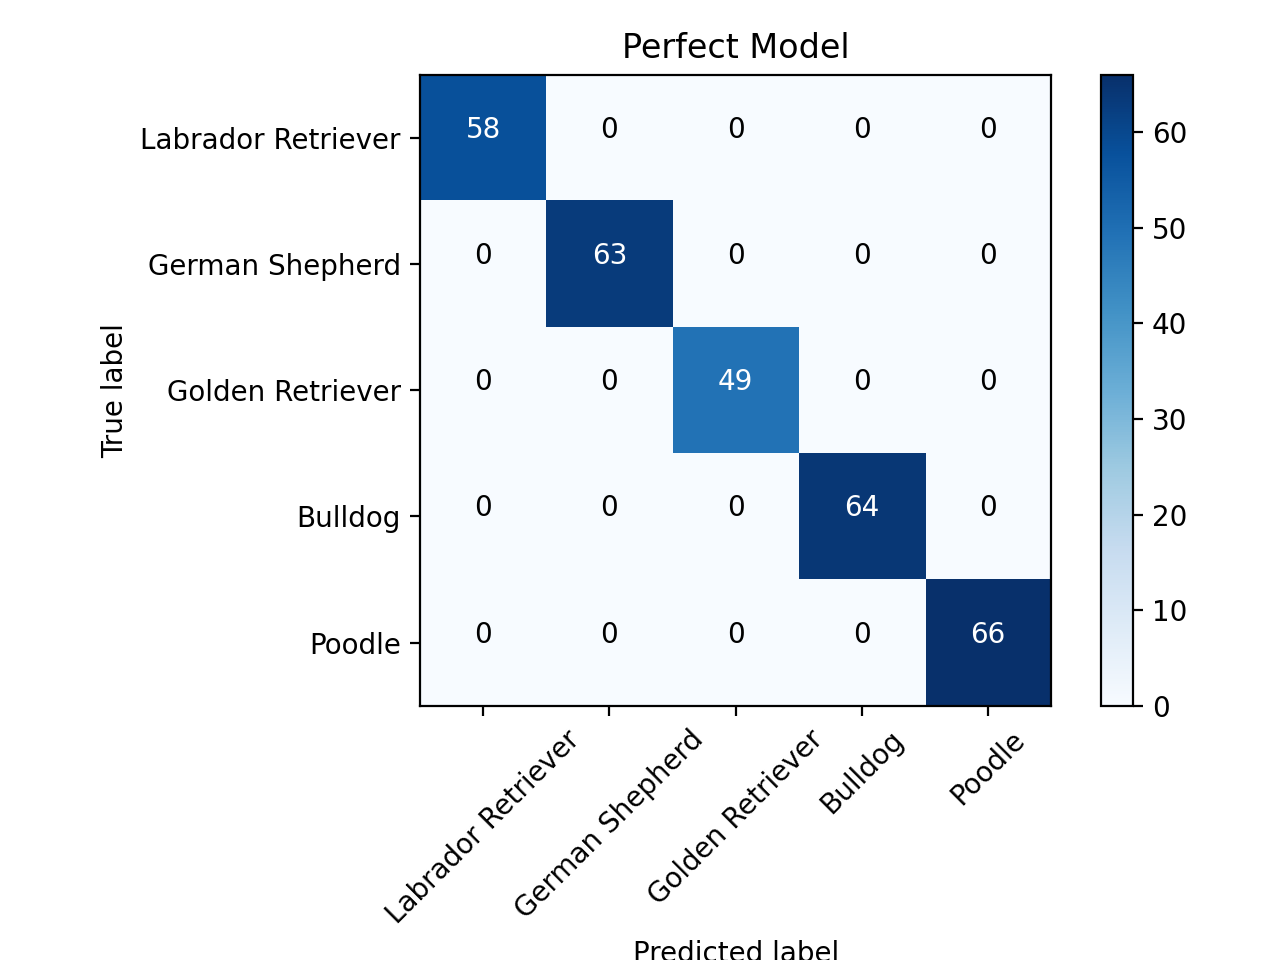

In [163]:
#confusion matrix ของโมเดลที่สมบูรณ์แบบ
cm = confusion_matrix(y_true=df.actual, y_pred=df.actual)
plot_confusion_matrix(cm,
                      classes=dog_breeds,
                      percentify_numbers = False,
                      title="Perfect Model")

ลองเปรียบเทียบกับโมเดลตัวอย่างของเรา (`pred`) จะเห็นได้ว่าโมเดลของเรามีความผิดพลาดประปราย เช่น ทายว่า `Golden Retriever` ทั้งที่เป็น `Poodle` 27 ตัว, ทายว่าเป็น `Bulldog` ทั้งที่เป็น `Golden Retriever` 17 ตัว เป็นต้น

ลองมาทำแบบฝึกหัดทบทวนความเข้าใจกัน
1. โมเดลทายว่าเป็น `Poodle` ทั้งที่จริงๆแล้วเป็น `Bulldog` กี่ตัว?
2. ในเหล่าหมาที่โมเดลทายว่าเป็น `Golden Retriever` แล้วเป็นพันธุ์นั้นจริงมีกี่ตัว?
3. โมเดลทายหมาที่จริงๆแล้วเป็น `German Sheperd` ผิดเป็นพันธุ์อะไรบ้าง-พันธุ์ละกี่ตัว?
4. ในเหล่าหมาที่โมเดลทายว่าเป็น `Poodle` จริงๆแล้วเป็นพันธุ์อะไรเยอะที่สุด-กี่ตัว?
5. โมเดลทายหมาที่จริงๆแล้วเป็น `Labrador Retriever` ผิดเป็นพันธุ์อะไรบ้าง-พันธุ์ละกี่ตัว?

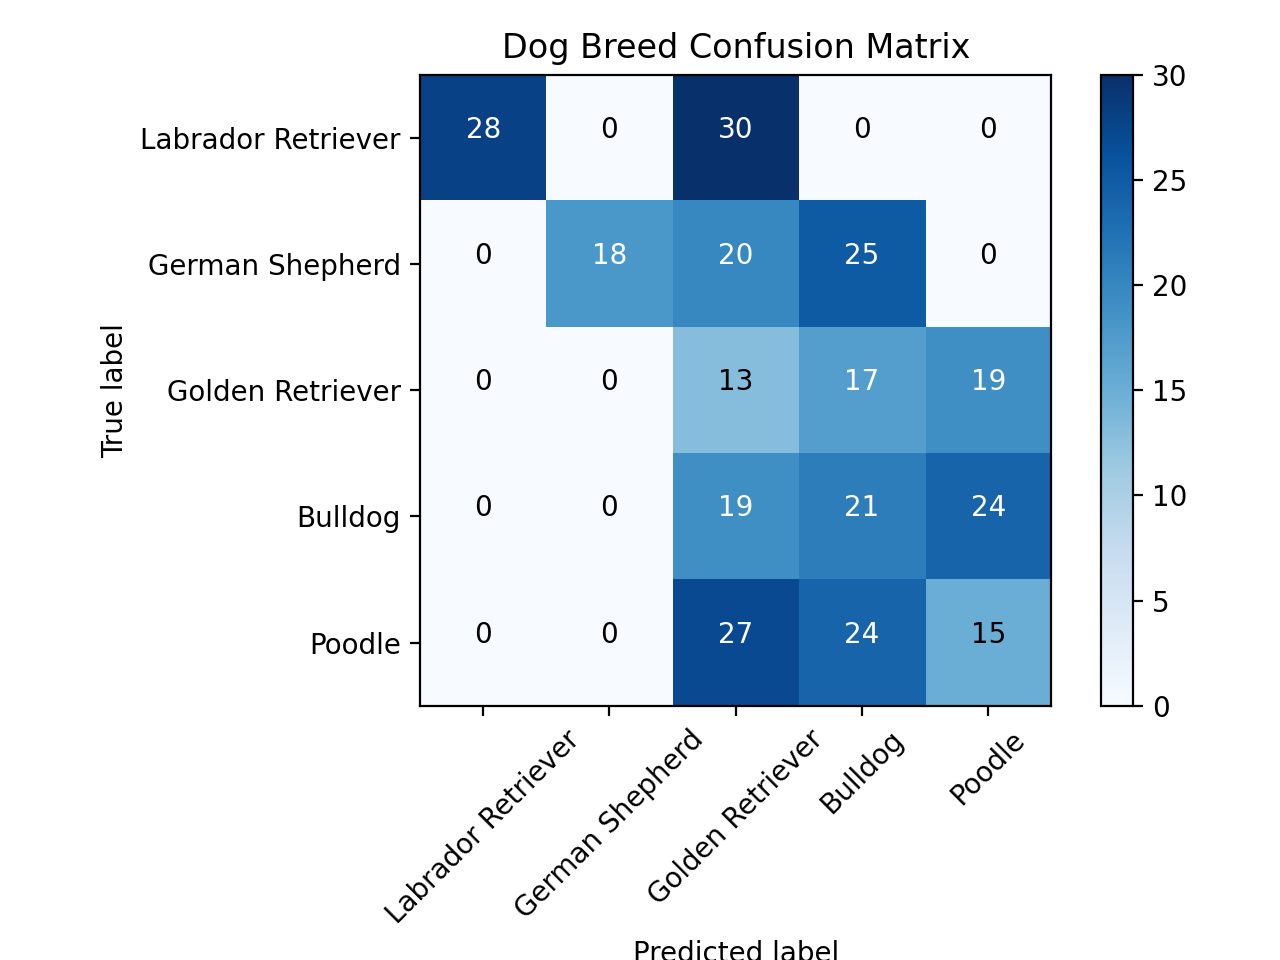

In [164]:
#confusion matrix ของโมเดลตัวอย่าง
cm = confusion_matrix(y_true=df.actual, y_pred=df.pred)
plot_confusion_matrix(cm,
                      classes=dog_breeds,
                      percentify_numbers = False,
                      title="Dog Breed Confusion Matrix")

**เฉลย**
1. 24 ตัว
2. 13 ตัว
3. `Golden Retriever` (20 ตัว) และ `Bulldog` (25 ตัว)
4. `Bulldog` (24 ตัว)
5. `Golden Retriever` (30 ตัว)

#### Common Classification Baselines

เรารู้ว่าโมเดลเราทำได้แย่กว่าโมเดลสมบูรณ์แบบ ในโลกแห่งความเป็นจริงแทบไม่มีโมเดลที่ทำได้สมบูรณ์แบบ จริงๆแล้วถ้าคุณทำโมเดลออกมาแล้วสมบูรณ์แบบ คุณน่าจะต้องสงสัยว่าคุณทำอะไรผิด แต่เราจะรู้ได้ยังไงว่าโมเดลของเราดีแค่ไหน? นี่คือเหตุผลว่าทำไมเราถึงต้องมี baseline เพื่อเปรียบเทียบ

Baseline ง่ายๆสำหรับการทำ classification มีได้เช่น

1. **โมเดลที่มีอยู่แล้ว**; แทบจะทุกปัญหาที่เราอยากแก้ (99.99%) จะมีคนที่พยามแก้มันอยู่แล้ว สิ่งแรกที่เราควรเปรียบเทียบกับโมเดลของเราจึงเป็นโมเดลที่ดีที่สุดในปัจจุบันที่คนอื่นทำไว้ หาได้ตาม [HuggingFace](https://huggingface.co/models), [Kaggle](https://www.kaggle.com/), [Google Scholar](https://scholar.google.com/), [Papers with Code](https://paperswithcode.com/) หรือ [Github](https://github.com/)

2. **กฎง่ายๆ**; บางครั้งปัญหาอาจจะถูกแก้อยู่ ด้วยกฎง่ายๆบางอย่าง เช่น หากเราเปิดธุรกิจปล่อยเงินกู้แล้วอยากทำนายว่าลูกค้าคนไหนให้กู้ไปแล้วจะใช้คืน (multi-class classification; labels = ใช้หนี้, เบี้ยวหนี้) เราอาจจะใช้กฎง่ายๆว่า `หากลูกค้ามีรายได้มากกว่า 20,000 บาทต่อเดือน เขาจะใช้หนี้เรา` และให้กู้เฉพาะคนที่มีรายได้มากกว่า 20,000 บาท หรือบางทีเราอาจจะ[เพิ่มความซับซ้อนเข้าไป](https://www.google.com/search?q=%E0%B8%9B%E0%B8%A3%E0%B8%B0%E0%B8%81%E0%B8%B1%E0%B8%99+%E0%B8%A7%E0%B8%B4%E0%B8%8A%E0%B8%B2%E0%B8%8A%E0%B8%B5%E0%B8%9E%E0%B9%81%E0%B8%9E%E0%B8%97%E0%B8%A2%E0%B9%8C)เพื่อให้กฎมีประสิทธิผลขึ้น เช่น `ต่อให้ลูกค้ามีรายได้ต่ำกว่า 20,000 บาทต่อเดือน แต่ถ้าเป็นข้าราชการ เขาจะใช้หนี้เรา เนื่องจากแหล่งรายได้แน่นอน` เป็นต้น แน่นอนว่ากฎง่ายๆเหล่านี้ย่อมทำนายได้ไม่ถูกมากนัก แต่เป็น baseline ที่ดีก่อนการใช้ ML มาช่วยแก้ปัญหา
```
[เรื่องน่ารู้] ธนาคารและบริษัทประกันหลายๆที่ยังใช้ "กฎง่ายๆ" ในรูปแบบที่ซับซ้อนยิ่งขึ้นด้วยการเพิ่มตัวแปร เช่น อาชีพ, สถานะสมรส,
ประวัติการตรวจสุขภาพ, ประวัติการใช้หนี้บัตรเครดิต ฯลฯ ในการปล่อยกู้หรือทำประกันอยู่ และได้ผลประกอบการดีโดยไม่ได้ใช้โมเดลมาช่วยแต่อย่างใด
```

3. **ดิ่งช้อยส์**; เลือกทำนายชนิดที่มีจำนวนมากที่สุดใน test set ในกรณีของเราคือ `Poodle`

4. **ทายมั่ว**; ทำนายมั่วๆไปเลยจากชนิดที่มีอยู่ (`pred_random`)

5. **เทียบกับมนุษย์**; baseline ที่น่าจะยากที่สุดสำหรับ ML model คือการเทียบว่ามันทำได้ดีแค่ไหนถ้าเทียบกับมนุษย์ ความยากลำบากของ baseline นี้คือหากเราต้องการผลการเปรียบเทียบเชิงปริมาณ (quantitatively) ที่มีนัยยะสำคัญทางสถิติเราอาจต้องให้มนุษย์จำนวนมาก-มาทำแบบทดสอบหลายข้อ หลายครั้งการเปรียบเทียบกับมนุษย์จึงทำได้เพียงคร่าวๆหรือในเชิงคุณภาพ (qualitatively) เท่านั้น

In [165]:
df.actual.value_counts()

actual
Poodle                66
Labrador Retriever    64
German Shepherd       63
Bulldog               58
Golden Retriever      49
Name: count, dtype: int64

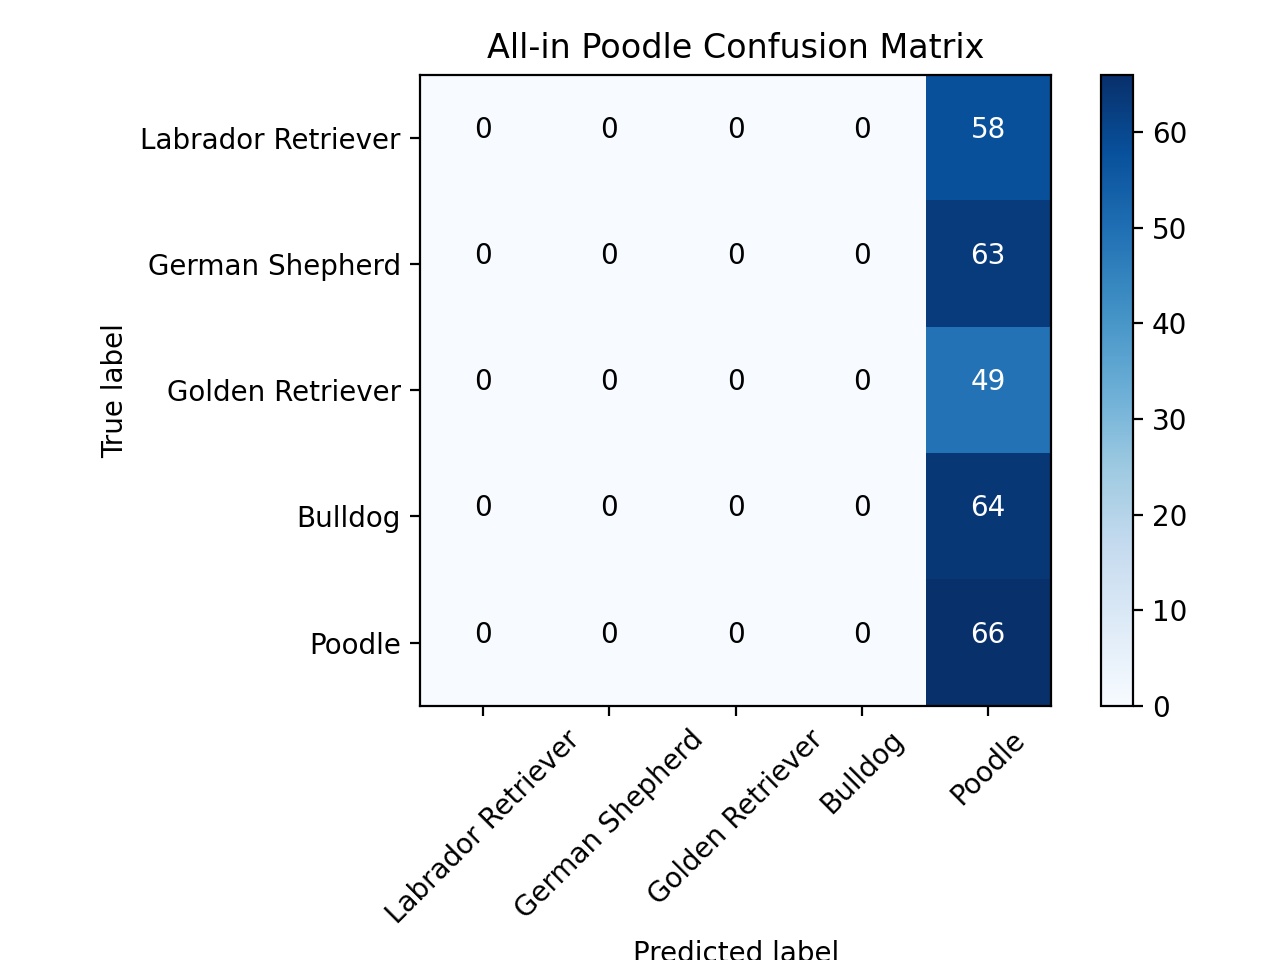

In [166]:
#confusion metric ของการดิ่ง Poodle
df['pred_majority'] = df.actual.value_counts().index[0]
cm = confusion_matrix(y_true=df.actual, y_pred=df.pred_majority)
plot_confusion_matrix(cm,
                      classes=dog_breeds,
                      percentify_numbers = False,
                      title="All-in Poodle Confusion Matrix")

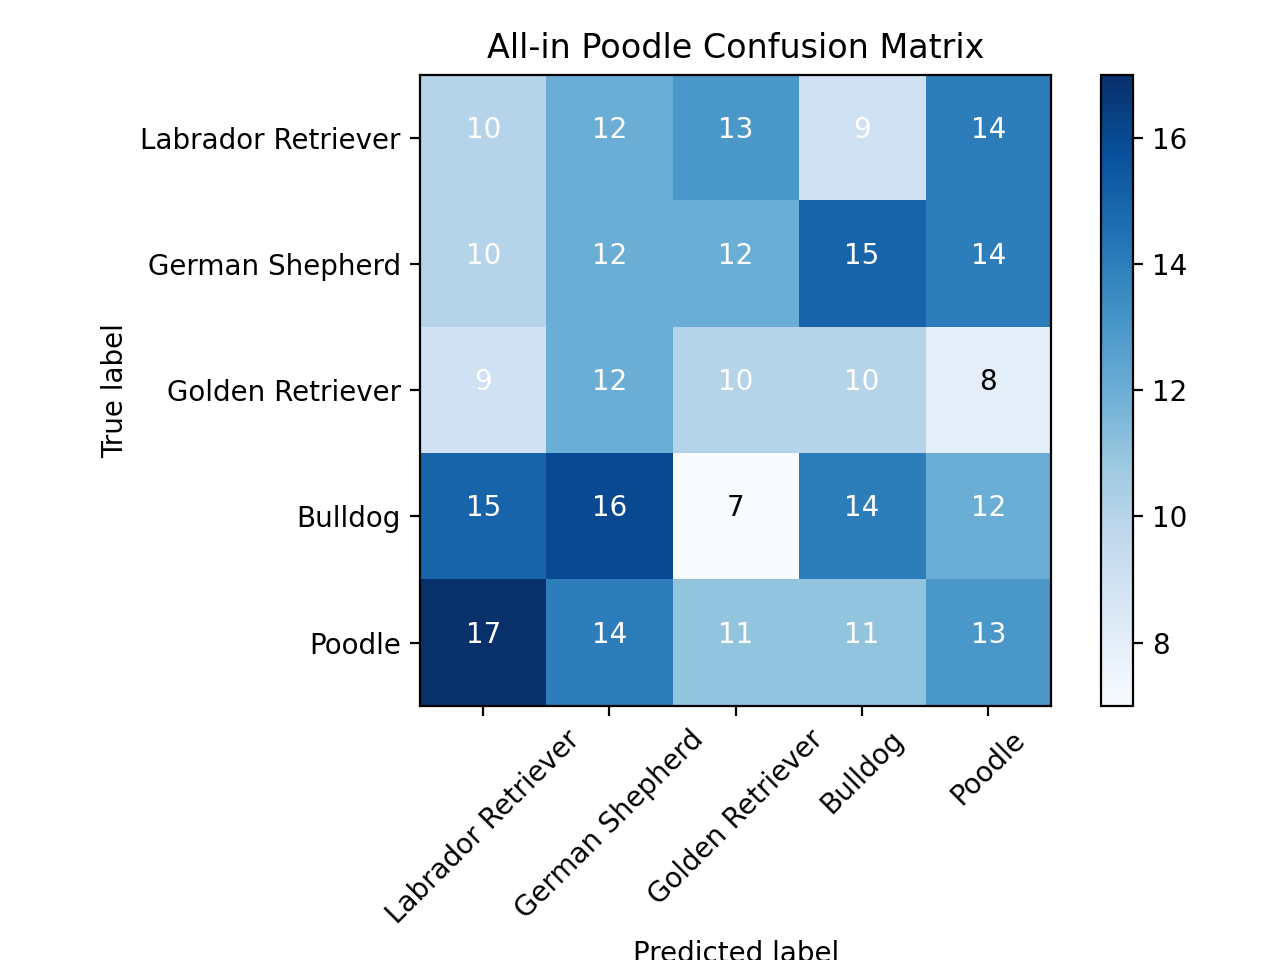

In [167]:
#confusion metric ของการทายมั่ว
cm = confusion_matrix(y_true=df.actual, y_pred=df.pred_random)
plot_confusion_matrix(cm,
                      classes=dog_breeds,
                      percentify_numbers = False,
                      title="All-in Poodle Confusion Matrix")

### Classification Metrics

หากดูด้วยตาเราอาจจะพอคาดการณ์ได้ว่าโมเดลตัวอย่างนั้นทำได้ดีกว่าการดิ่ง Poodle และทายมั่ว แต่เราไม่สามารถดูด้วยตาแบบนี้ได้ในทุกกรณี โดยเฉพาะกรณีที่มีโมเดลที่มีประสิทธิภาพใกล้เคียงกันหรือกรณีที่เราต้องการเปรียบเทียบโมเดลหลายๆโมเดลพร้อมๆกัน เราจึงต้องคำนวณ metric 1 ตัวเลขต่อ 1 โมเดลจากข้อมูล confusion matrix ข้างต้น เพื่อง่ายต่อการเปรียบเทียบ

Metric พื้นฐานเหล่านั้นได้แก่

1. **Accuracy**; ทำนายถูกหรือผิดกี่ตัวอย่างจากทั้งหมด; ผลรวมของจำนวนตัวอย่างใน`เส้นทแยงมุม`ของ confusion matrix หารด้วยจำนวน`ตัวอย่างทั้งหมด`


2. **Precision**; จากตัวอย่างที่โมเดลทำนายเป็น label นั้นๆ มีถูกกี่อัน; จำนวนตัวอย่างที่ทายถูกใน`คอลัมน์นั้นๆ`หารด้วยผลรวมของจำนวนตัวอย่างทั้งหมดใน`คอลั่มน์`


3. **Recall**; จากตัวอย่างที่เป็น label นั้นๆจริง โมเดลทำนายถูกกี่อัน; จำนวนตัวอย่างที่ทายถูกใน`แถวนั้นๆ`หารด้วยผลรวมของจำนวนตัวอย่างทั้งหมดใน`แถว`

4. **F-score**; ค่า harmonic mean ของ precision และ recall; F-score ที่นิยมใช้ที่สุดคือ F1-score ที่ให้ค่าความสำคัญของ precision และ recall เท่ากัน นอกจากนั้นยังมี F0.5 ที่ให้ความสำคัญของ precision มากกว่า หรือ F2 ที่ให้ความสำคัญของ recall มากกว่า สนใจอ่านต่อได้[ที่นี่](https://machinelearningmastery.com/fbeta-measure-for-machine-learning/)

5. **AUROC**; พื้นที่ใต้เส้นโค้ง false positive rate และ recall (true positive rate)

6. **(Area under) Precision-recall curve**; (พื้นที่ใต้)เส้นโค้ง precision และ recall

#### Accuracy, Precision, Recall, and F1

Accuracy เป็น metric ที่ตรงไปตรงมามากที่สุด ยิ่งสูงยิ่งแสดงว่าโมเดลทำนายได้ตรง label ที่แท้จริงบ่อย แต่ในความตรงไปตรงมานี้อาจทำให้เรามองไม่เห็นภาพที่สมบูรณ์เกี่ยวกับประสิทธิผลของโมเดลของเรา เราจึงต้องเสริมด้วยการดู metric อื่น เช่น precision และ recall

```
[หยุดคิดสักนิด] กรณีไหนที่หากเราดูแค่ accuracy จะทำให้เราประเมินประสิทธิผลของโมเดลเราผิด?
```

การเลือกใช้ precision และ recall นั้น เราต้องทำความเข้าใจ false positive (ทำนายว่าเป็น label นั้น แต่จริงๆไม่ใช่) และ false negative (ทำนายว่าไม่ได้เป็น label นั้นแต่จริงๆเป็น)

**เราสนใจ precision มากเป็นพิเศษเมื่อราคาของ false positive นั้นสูง** เช่น ทำนายหุ้นที่ซื้อแล้วจะขึ้น หากเราทำนายตัวที่จะซื้อผิด (false positive) เราเสียเงินทันที ในทางกลับกัน ต่อให้เราไม่ซื้อหุ้นที่จริงๆแล้วจะขึ้น (false negative) เราก็แค่เสียโอกาส

**เราสนใจ recall มากเป็นพิเศษเมื่อราคาของ false negative นั้นสูง** เช่น การตรวจมะเร็ง หากเราทำนายว่าคนที่เป็นมะเร็งจริงๆไม่เป็น (false negative) อาจจะก่อให้เกิดความล่าช้าในการรักษาส่งผลต่อสุขภาพทันที ในทางกลับกันถ้าเราทำนายว่าเขาเป็นทั้งๆที่ไม่ได้เป็น (false positive) เขาอาจจะต้องเสียเวลาตรวจละเอียดมากขึ้น แต่ไม่ได้มีผลต่อสุขภาพ

In [168]:
#ดูว่าเราทายพันธุ์อะไรไปบ้าง
df.pred.value_counts()

pred
Golden Retriever      109
Labrador Retriever     87
Poodle                 58
Bulldog                28
German Shepherd        18
Name: count, dtype: int64

In [169]:
df.pred.value_counts(normalize=True)

pred
Golden Retriever      0.363333
Labrador Retriever    0.290000
Poodle                0.193333
Bulldog               0.093333
German Shepherd       0.060000
Name: proportion, dtype: float64

In [170]:
#classification metric สำหรับโมเดลตัวอย่าง
cr = classification_report(y_true=df.actual,
                          y_pred=df.pred,
                          labels=dog_breeds)
print(cr)

                    precision    recall  f1-score   support

Labrador Retriever       0.24      0.33      0.28        64
   German Shepherd       1.00      0.29      0.44        63
  Golden Retriever       0.12      0.27      0.16        49
           Bulldog       1.00      0.48      0.65        58
            Poodle       0.26      0.23      0.24        66

          accuracy                           0.32       300
         macro avg       0.52      0.32      0.36       300
      weighted avg       0.53      0.32      0.36       300



เนื่องจากเราคำนวณ metric สำหรับแต่ละ label แยกกัน เราจึงต้องมีวิธีการหาค่าเฉลี่ยระหว่าง label ด้วย

1. Macro-average; นำค่า precision, recall, F1 จากแต่ละ label มาหาค่าเฉลี่ยกัน
2. Micro-average/Weighted average; หาค่าเฉลี่ยที่ถ่วงน้ำหนักด้วยจำนวนตัวอย่างในแต่ละ label (`support`)

In [171]:
#วิธีคำนวน macro-average precision
macro_precision = (0.24+1.0+0.12+1.0+0.26)/5
macro_precision

0.524

In [172]:
#วิธีคำนวน macro-average recall
macro_recall = (0.33+0.29+0.27+0.48+0.23)/5
macro_recall

0.32

In [173]:
#วิธีคำนวน micro-average precision
micro_precision = (0.24*64 + \
                   1.0*63+ \
                   0.12*49+ \
                   1.0*58+ \
                   0.26*66)/300
micro_precision

0.5313333333333333

In [174]:
#วิธีคำนวน micro-average recall
micro_recall = (0.33*64 + \
                   0.29*63+ \
                   0.27*49+ \
                   0.48*58+ \
                   0.23*66)/300
micro_recall

0.31880000000000003

In [175]:
#วิธีคำนวน f1 ของ Labrador Retriever
#คำนวณ micro-average / macro-average ด้วยวิธีเดียวกับ precision และ recall
def harmonic_mean(a, b):
    return (2 * a * b) / (a + b)

harmonic_mean(0.24, 0.33)

0.27789473684210525

```
[คำถามชวนคิด] คุณสามารถคำนวน accuracy จากตารางข้างต้นที่มีเพียง precision, recall, support ได้หรือไม่-เพราะอะไร?
```

In [176]:
#classification metric สำหรับการดิ่ง Poodle
cr = classification_report(y_true=df.actual,
                          y_pred=df.pred_majority,
                          labels=dog_breeds)
print(cr)

                    precision    recall  f1-score   support

Labrador Retriever       0.00      0.00      0.00        64
   German Shepherd       0.00      0.00      0.00        63
  Golden Retriever       0.00      0.00      0.00        49
           Bulldog       0.00      0.00      0.00        58
            Poodle       0.22      1.00      0.36        66

          accuracy                           0.22       300
         macro avg       0.04      0.20      0.07       300
      weighted avg       0.05      0.22      0.08       300



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [177]:
#classification metric สำหรับการทายมั่ว
cr = classification_report(y_true=df.actual,
                          y_pred=df.pred_random,
                          labels=dog_breeds)
print(cr)

                    precision    recall  f1-score   support

Labrador Retriever       0.24      0.22      0.23        64
   German Shepherd       0.18      0.19      0.19        63
  Golden Retriever       0.19      0.20      0.20        49
           Bulldog       0.16      0.17      0.17        58
            Poodle       0.21      0.20      0.20        66

          accuracy                           0.20       300
         macro avg       0.20      0.20      0.20       300
      weighted avg       0.20      0.20      0.20       300



##### Label Imbalance and Macro/Micro-Average

หากจำนวนตัวอย่างในแต่ละ label มีเท่าๆกัน macro-average และ micro-average จะออกมาใกล้เคียงกัน แต่ในกรณีที่มีบาง label มีจำนวนตัวอย่างมากหรือน้อยเป็นพิเศษ การใช้ micro-average จะทำให้ metric เฉลี่ยดูดีหาก metric ของ label ที่มีจำนวนตัวอย่างมากเป็นพิเศษออกมาดี

ในกรณีที่จำนวนตัวอย่างใน label ต่างกันมาก ยกตัวอย่างกรณีโมเดลตรวจโรค แน่นอนว่าคนส่วนใหญ่ที่มาตรวจสุขภาพนั้นไม่ได้เป็นโรค ในกรณีนี้หากเราใช้ accuracy หรือ micro-average ในการคำนวณ metric อาจจะได้ผลสรุปที่ไม่ตรงความจริง

In [178]:
#ตัวอย่าง multi-class classification
labels = ['Healthy','Diseased']
np.random.seed(125)
num_samples = 300
actuals = np.random.choice(labels, size=num_samples, p=[0.99,0.01])

# Create the dataframe
df = pd.DataFrame({'actual': actuals, 'pred': 'Healthy'})
df

,actual,pred
0,Healthy,Healthy
1,Healthy,Healthy
2,Healthy,Healthy
3,Healthy,Healthy
4,Healthy,Healthy
...,...,...
295,Healthy,Healthy
296,Healthy,Healthy
297,Healthy,Healthy
298,Healthy,Healthy


จากตัวอย่าง ถ้า 99% ของคนไข้สุขภาพดี เพียงแค่เราทำนายว่าทุกคนจะสุขภาพดี เราก็จะได้ accuracy และ micro-average ที่สูงมาก แต่หากดู confusion matrix เราก็จะรู้ว่าโมเดลไม่ได้ทำได้ดีเลย กรณีแบบนี้เราจึงควรใส่ใจ macro-average มากกว่า

In [179]:
cr = classification_report(y_true=df.actual,
                          y_pred=df.pred,
                          labels=labels)
print(cr)

              precision    recall  f1-score   support

     Healthy       0.99      1.00      0.99       297
    Diseased       0.00      0.00      0.00         3

    accuracy                           0.99       300
   macro avg       0.49      0.50      0.50       300
weighted avg       0.98      0.99      0.99       300



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


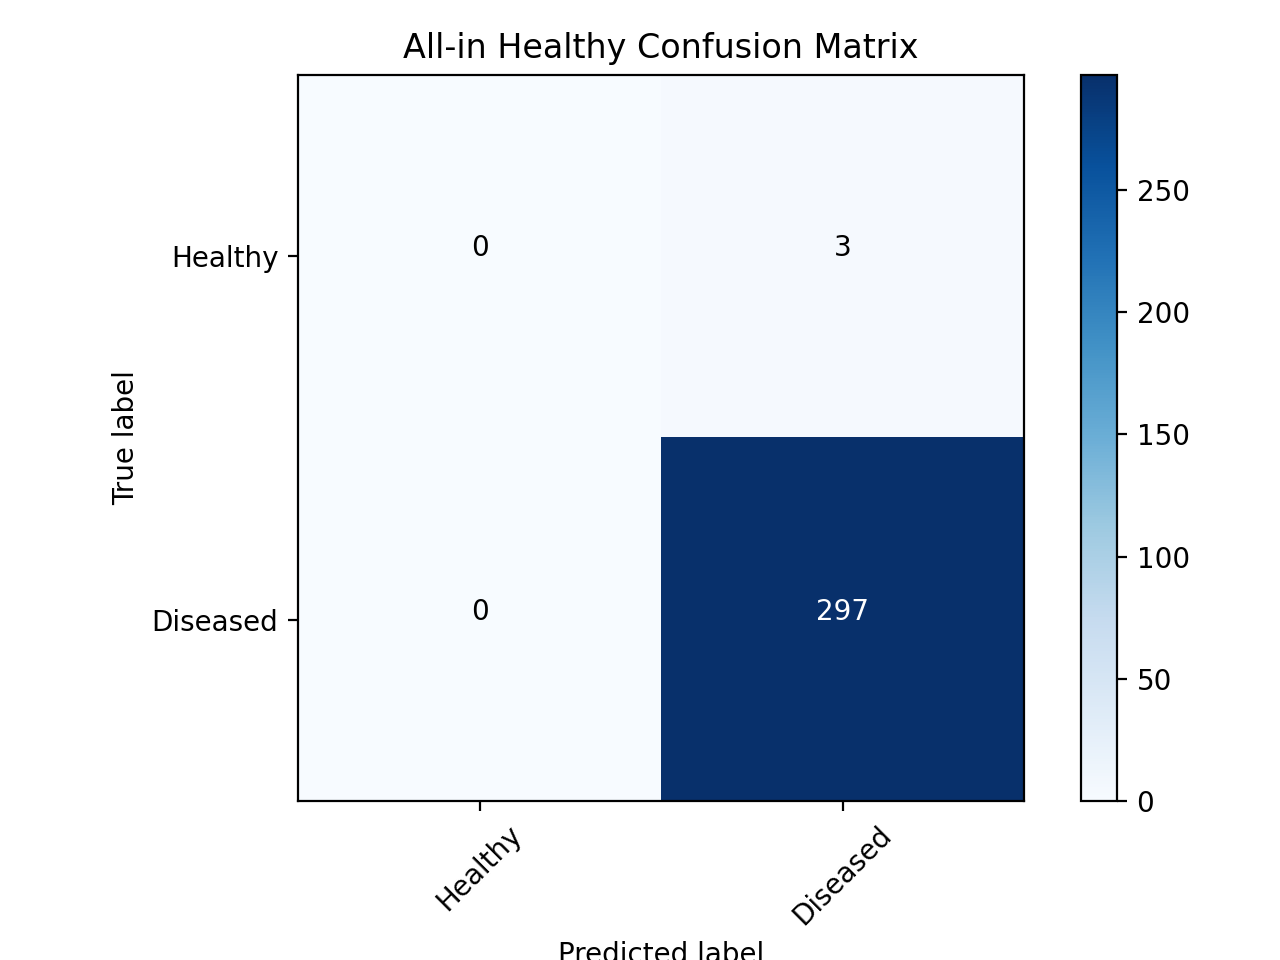

In [180]:
#confusion metric ของการดิ่ง Healthy
cm = confusion_matrix(y_true=df.actual, y_pred=df.pred)
plot_confusion_matrix(cm,
                      classes=labels,
                      percentify_numbers = False,
                      title="All-in Healthy Confusion Matrix")

#### [Optional] AUROC

AUROC ย่อมาจาก Area under Receiver Operating Characteristic (ROC) Curve จุดเด่นของ metric นี้นอกจากชื่อที่เข้าใจยากแล้วคือการคำนวณประสิทธิผลด้วย predicted probability (เช่น มีโอกาสเป็นพันธุ์ไหนกี่ %) ของแต่ละตัวอย่าง แทนที่จะเป็น prediction (เช่น พันธุ์หมา) ตรงๆเหมือน accuracy, precision, recall, f-score

```
[เรื่องน่ารู้] มันเรียกว่า receiver operating characteristic curve เพราะถูกประดิษฐ์ขึ้นครั้งแรกระหว่างสงครามโลกครั้งที่ 2 โดยวิศวกรเรดาร์
เพื่อวัดประสิทธิภาพของเรดาร์ (receiver) ตรวจจับศัตรู
จาก: https://stats.stackexchange.com/questions/341043/what-is-the-origin-of-the-receiver-operating-characteristic-roc-terminology
```

เราจะมาทำความเข้าใจ metric นี้ด้วยชุดข้อมูลที่มี positive/negative (`1`/`0`) ประมาณ 50/50; สมมุติว่าเราสร้าง 1) โมเดลที่ทำนาย predicted probability (`model_prob`) ที่ค่อนข้างแม่นยำและ 2) ทำนายมั่วตั้งแต่ 0.0 ถึง 1.0 (`random_prob`)

ชุดข้อมูลนี้สร้างขึ้นจากการสุ่ม true probability ระหว่าง 0 ถึง 1 แล้วให้ label เป็น positive (`1`) หาก true probability มีค่ามากกว่า 0.5 ก็จะได้ตัวอย่างที่เป็น positive/negative 50/50 พอดี; อย่าลืมว่าในโลกแห่งความเป็นจริง โดยทั่วไปแล้ว เราไม่สามารถสังเกต true probability นี้ได้

In [181]:
num_samples = 1000

np.random.seed(125)
#สุ่ม "ความน่าจะเป็นที่แท้จริง"
actual_probabilities = np.random.uniform(0, 1, size=num_samples)
#สร้าง "โมเดล" ให้ทำนาย "ความน่าจะเป็นที่แท้จริง" +/- 0.5
predicted_probabilities = actual_probabilities + np.random.uniform(-0.5, 0.5, size=num_samples).clip(0,1)

np.random.seed(126)
random_probabilities = np.random.uniform(0, 1, size=num_samples)

actuals = (actual_probabilities > 0.5).astype(int)

#ทำนายว่า positive ถ้า predicted probabilties สูงกว่า 0.5
preds = (predicted_probabilities > 0.5).astype(int)
random_preds = (random_probabilities > 0.5).astype(int)

df = pd.DataFrame({
    'actual': actuals,
    'random_prob': random_probabilities,
    'random_pred_50': random_preds,
    'model_prob': predicted_probabilities,
    'model_pred_50': preds
})
df

,actual,random_prob,random_pred_50,model_prob,model_pred_50
0,1,0.105172,0,0.506726,1
1,0,0.128144,0,0.486692,0
2,1,0.087406,0,0.737615,1
3,0,0.115479,0,0.132553,0
4,0,0.747728,1,0.131085,0
...,...,...,...,...,...
995,1,0.153264,0,0.660039,1
996,1,0.146143,0,1.127926,1
997,0,0.731790,1,0.315999,0
998,0,0.284684,0,0.484264,0


In [182]:
#support
df.actual.value_counts(normalize=True)

actual
1    0.517
0    0.483
Name: proportion, dtype: float64

เราจะเห็นได้ว่าถ้าเราเลือก cutoff เป็น 0.5 (หาก predicted probability สูงกว่า 0.5 ให้ทำนายเป็น positive; นอกนั้น negative) โมเดลของเราจะมี accuracy สูงกว่าการทายมั่วอย่างเห็นได้ชัด

```
[เรื่องน่ารู้] เราสามารถหา cutoff ที่ได้ผลดีที่สุดสำหรับโมเดลของเราได้ง่ายๆด้วยการ
1) แบ่งชุดข้อมูลเป็น train/validation/test อาจจะประมาณ 80/10/10
2) ลองคำนวณ metric ด้วยทุก cutoff เช่น ตั้งแต่ 0.01, 0.02, 0.03, ..., 0.99 บน validation set
3) เมื่อได้ cutoff ที่ได้ผลดีที่สุดใน validation set แล้วจึงใช้ optimal cutoff นั้นบน test set เพื่อคำนวณประสิทธิผลของโมเดลที่แท้จริง
```

In [183]:
# "model" accuracy
(df.actual==df.model_pred_50).mean()

0.877

In [184]:
# random accuracy
(df.actual==df.random_pred_50).mean()

0.473

เราสามารถวาด ROC Curve สำหรับ 1) โมเดลและ 2) การทายมั่วได้ดังต่อไปนี้

In [185]:
def roc_curve_coordinates(actual,
                        prob,
                        cutoffs=[i/100 for i in range(101)]):
    fpr = np.zeros(len(cutoffs))
    recall = np.zeros(len(cutoffs))

    # Loop over each threshold
    for i, cutoff in enumerate(cutoffs):
        pred = (prob >= cutoff).astype(int)
        tp = np.sum((pred == 1) & (actual == 1))
        fp = np.sum((pred == 1) & (actual == 0))
        tn = np.sum((pred == 0) & (actual == 0))
        fn = np.sum((pred == 0) & (actual == 1))
        fpr[i] = fp / (fp + tn) if (fp + tn) > 0 else 0.0
        recall[i] = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    return pd.DataFrame({
        'fpr': fpr,
        'recall': recall,
        'cutoff': cutoffs
    })


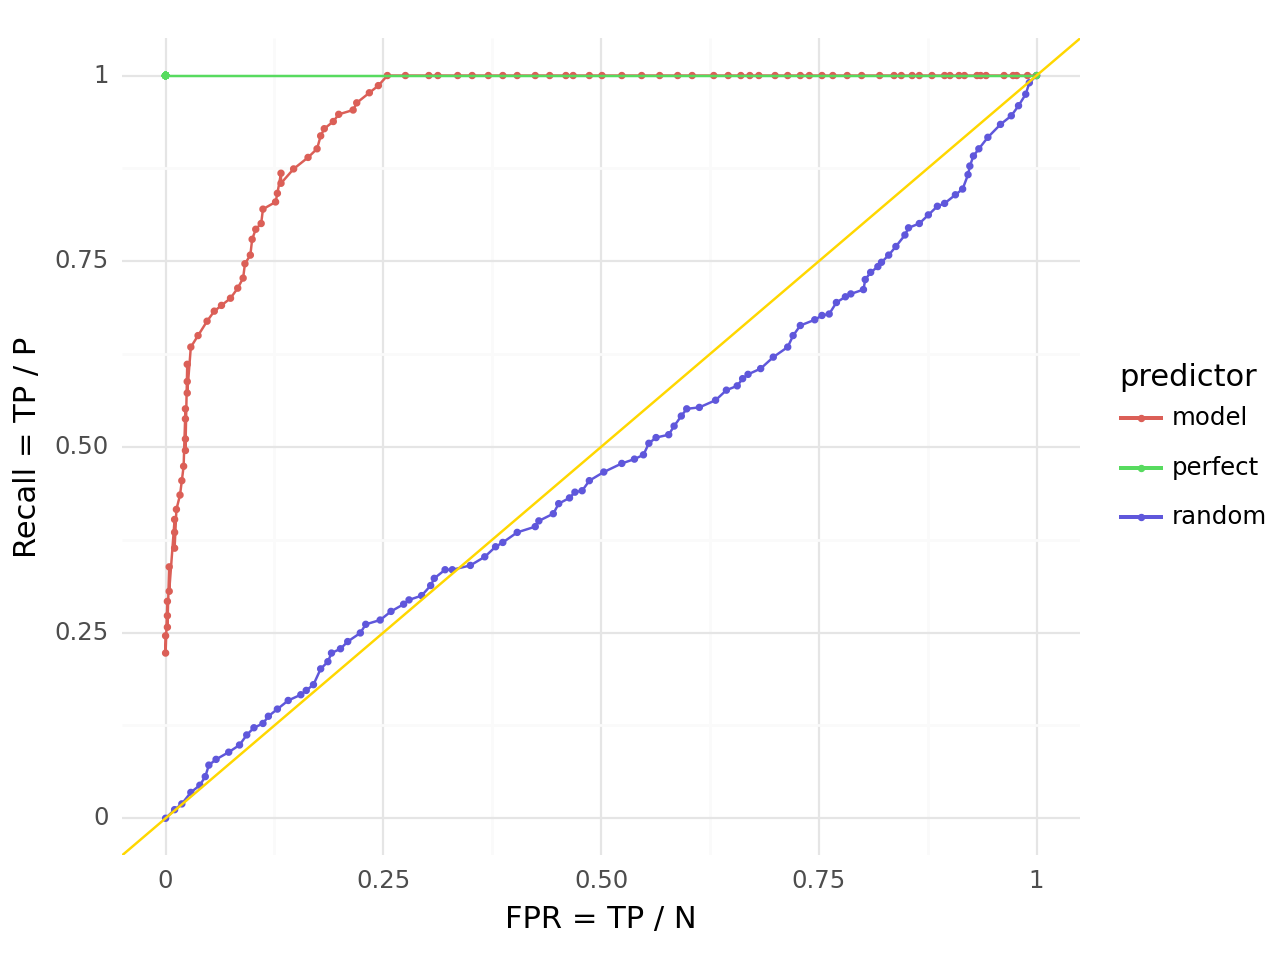

<Figure Size: (640 x 480)>

In [186]:
model_roc = roc_curve_coordinates(
    df.actual,
    df.model_prob
)
model_roc['predictor'] = 'model'
random_roc = roc_curve_coordinates(
    df.actual,
    df.random_prob
)
random_roc['predictor'] = 'random'
perfect_roc = roc_curve_coordinates(
    df.actual,
    df.actual
)
perfect_roc['predictor'] = 'perfect'

plot_df = pd.concat([model_roc,random_roc,perfect_roc],axis=0).reset_index(drop=True)
g = (ggplot(plot_df, aes(x='fpr',y='recall',color='predictor'))+
     geom_point(size=0.5) + geom_line() +
     geom_abline(slope=1, intercept = 0, color='gold') +
     ylab('Recall = TP / P') + xlab('FPR = TP / N')
)
g

เรามาเริ่มถอดความจาก ROC Curve กันก่อน ใช้โจทย์แยก `1` กับ `0` เป็นตัวอย่าง positive คือ `1`

เส้นโค้งนี้อยู่บนแกน
* X = False Positive Rate; จากตัวอย่างที่ negative (`0`) จริงๆทั้งหมด โมเดลทายผิดเป็น positive (`1`) กี่ %
* Y = Recall; จากตัวอย่างที่ positive (`1`) จริงๆทั้งหมด โมเดลทายถูกว่าเป็น positive (`1`) กี่ %

โดยที่แต่ละจุดคือพิกัด `(False Positive Rate, Recall)` ที่คำนวณจากการให้โมเดลทำนาย positive (`1`) หาก predicted probability สูงกว่าค่าใดค่าหนึ่ง (นิยมเรียกว่า cutoff หรือ threshold) โดยทั่วไปอาจจะไล่พลอตจาก 0.01, 0.02, ... 1.00 แล้วเชื่อมทุกจุดเข้ากันเป็นเส้น

เราจะเห็นได้ว่าเส้นโค้งที่ทำนาย perfect (predicted probabilities = label) จะเป็นเส้นตรงขนานแกน X ตัดแกน Y ที่ 1 และเส้นโค้งที่ทำนายมั่วจะเกือบๆเป็นเส้นทำมุม 45 องศากับแกน X (X=Y) และเส้นโค้งของโมเดลอยู่ระหว่างกลางของสองเส้นนี้

แน่นอนว่าเวลาเราทำโมเดลเราอยากทำให้เส้นโค้งของมันเข้าใกล้เส้นโค้งที่ทำนาย perfect เท่าที่จะทำได้ เราจึงคิด metric ที่คำนวณพื้นที่ใต้เส้นโค้งนี้ขึ้นมาเรียกว่า Area under the Receiver Operating Characteristic Curve หรือ AUROC มีค่าระหว่าง 0 ถึง 1 (0.5 เท่ากับทายมั่ว)

จุดเด่นของการพลอต ROC Curve คือทำให้เราเปรียบเทียบประสิทธิผลของโมเดลโดยไม่จำเป็นต้องขึ้นกับ cutoff อันใดอันหนึ่ง แต่เป็นการเปรียบเทียบในทุก cutoff ที่เป็นไปได้พร้อมกัน

```
[ข้อควรระวัง] AUROC บอกได้ว่าโมเดลไหนดีกว่า **โดยเฉลี่ยจากทุกๆ cutoff** ไม่ได้บอกว่าดีกว่าใน cutoff ที่ดีที่สุด
และไม่ได้บอกว่าดีกว่ากันแค่ไหนอีกด้วย เช่น AUROC = 0.8 ไม่ได้ดีกว่า AUROC = 0.4 สองเท่า
```


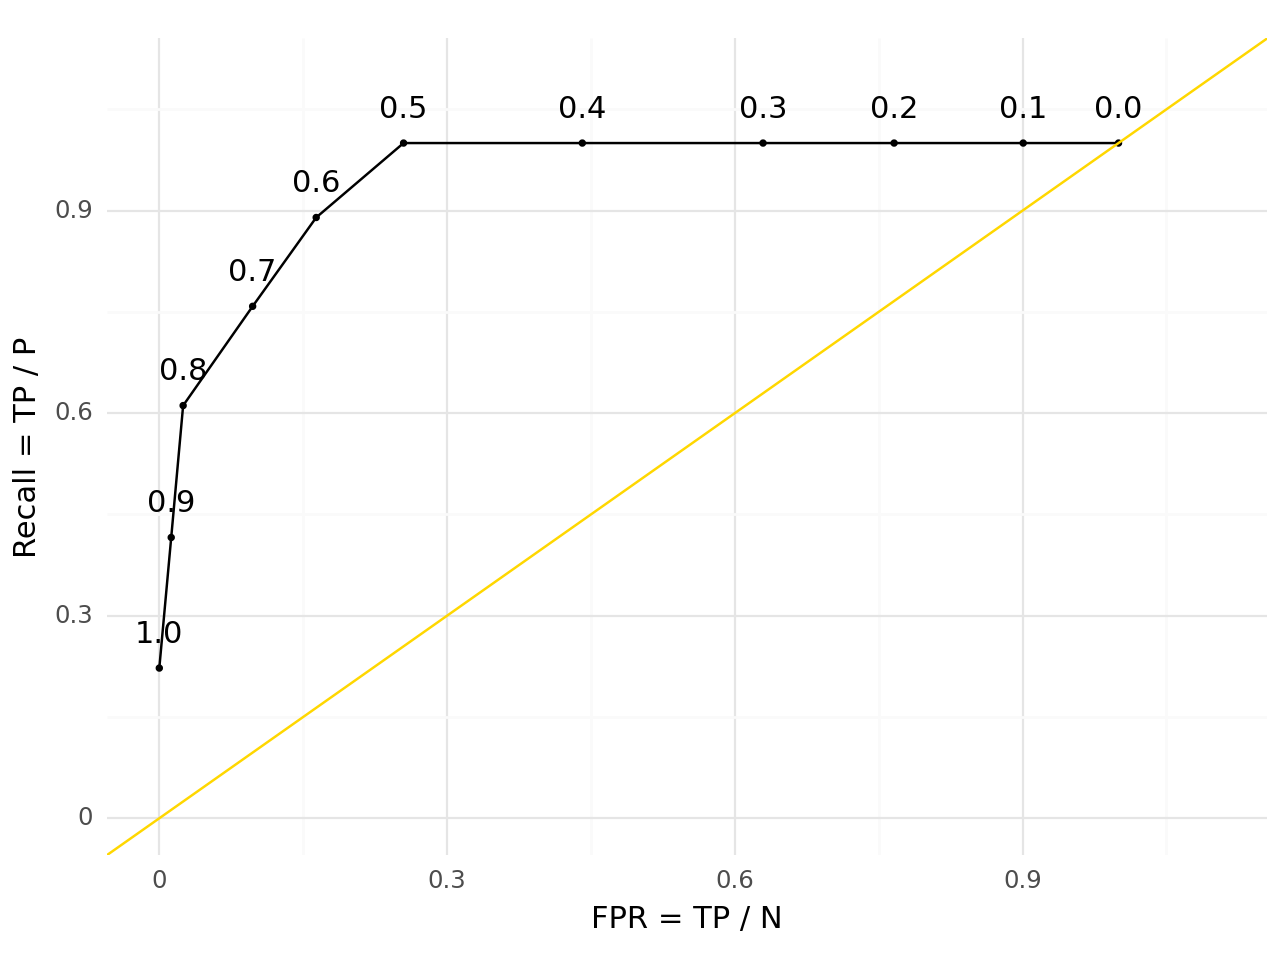

<Figure Size: (640 x 480)>

In [187]:
model_roc = roc_curve_coordinates(
    df.actual,
    df.model_prob,
    cutoffs=[i/10 for i in range(11)])


g = (ggplot(model_roc, aes(x='fpr',y='recall'))+
     geom_point(size=0.5) + geom_line() + expand_limits(x = [0,1.1], y = [0,1.1]) +
     geom_abline(slope=1, intercept = 0, color='gold') +
     geom_text(aes(x='fpr',y='recall+0.05',label='cutoff'))+
     ylab('Recall = TP / P') + xlab('FPR = TP / N')
)
g

คำอธิบายแบบง่ายๆว่าทำไมพื้นที่นี้ยิ่งเยอะยิ่งดีคือ หาก cutoff สูงขึ้น โมเดลจะมีทั้ง false positive rate และ recall ที่ต่ำลง เนื่องจากมันจะทายว่า positive ได้ยากขึ้น (ต้อง "มั่นใจ" / มี predicted probability สูงขึ้น) เราอยากให้ false positive rate ลดลงด้วยอัตราความเร็วที่สูงกว่า recall (เพราะ recall ยิ่งสูงยิ่งดีและ false positive rate ยิ่งต่ำยิ่งดี) ปรากฎการณ์ที่ recall ลดลงช้ากว่า false positive rate นี้หากคุณลองวาดลงไปบนพลอตก็จะเห็นเป็นรูปร่างคล้ายๆกับโมเดลของเรา ลองดูสิ!


In [188]:
#คำนวณ auroc ด้วย sklearn
from sklearn.metrics import roc_auc_score
roc_auc_score(y_true=df.actual, y_score=df.model_prob)

0.9475593786417098

In [189]:
#ลองดูเองว่า cutoff สูงขึ้น-ต่ำลง recall, fpr จะเปลี่ยนไปยังไง
from sklearn.metrics import recall_score, confusion_matrix
def fpr(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    return fp / (fp + tn)

cutoff = 0.5
print(f'''
cutoff: {cutoff}
recall: {recall_score(df.actual, (df.model_prob>cutoff).astype(int))}
fpr: {fpr(df.actual, (df.model_prob>cutoff).astype(int))}
''')

cutoff = 0.6
print(f'''
cutoff: {cutoff}
recall: {recall_score(df.actual, (df.model_prob>cutoff).astype(int))}
fpr: {fpr(df.actual, (df.model_prob>cutoff).astype(int))}
''')


cutoff: 0.5
recall: 1.0
fpr: 0.2546583850931677


cutoff: 0.6
recall: 0.8897485493230174
fpr: 0.16356107660455488



#### [Optional] AUPRC

อีกหนึ่ง metric ที่ได้รับความนิยมใช้ควบคู่กับ AUROC คือ Area under the precision-recall curve (AUPRC) มีความเข้าใจผิดอย่างแพร่หลายว่า metric นี้ช่วย "แก้ปัญหา" ของ AUROC ในกรณีที่มี label imbalance แต่นั่นไม่ใช่เรื่องจริงเสียทีเดียวสิ่งที่เกิดขึ้นคือ *มันดูเป็นแบบนั้น* เพราะพฤติกรรมบางอย่างของ AUPRC

AUROC ก็ยังใช้ได้ในกรณีที่มี label imbalance ใครที่สนใจอ่านเพิ่มเติมได้[ที่นี่](https://arxiv.org/pdf/2401.06091.pdf)

แล้วสิ่งที่ AUPRC บอกเรานั้นคืออะไร? เพื่อให้เห็นภาพเรามาลองดูตัวอย่างจากชุดข้อมูลเดิม โดยเปลี่ยนให้ positive มีแค่ 2% จากตัวอย่างทั้งหมด (20 ใน 1,000) จากประมาณ 50/50 (ประมาณ 500 ใน 1,000) โดยให้เลือกตัวอย่างที่มี true probability มากกว่า 0.98 เป็นต้นไปเท่านั้นจึงจะเป็น positive

1. Model A; ทำนายค่า true probability (ไม่สามารถสังเกตได้ในโลกแห่งความเป็นจริง) +/- 0.1

2. Model B; ทำนายค่า true probability (ไม่สามารถสังเกตได้ในโลกแห่งความเป็นจริง) +/- 0.2

โดยทั่วไปแล้ว Model A ควรมีประสิทธิผลดีกว่า Model B

```
[เรื่องน่ารู้] % positive ในชุดข้อมูลเรียกว่า prevalence
```

In [190]:
num_samples = 1000

np.random.seed(125)
actual_probabilities = np.random.uniform(0, 1, size=num_samples)
np.random.seed(126)
predicted_a_probabilities = (actual_probabilities + np.random.uniform(-0.1, 0.1, size=num_samples)).clip(0,1)
np.random.seed(127)
predicted_b_probabilities = (actual_probabilities + np.random.uniform(-0.2, 0.2, size=num_samples)).clip(0,1)
np.random.seed(128)
random_probabilities = np.random.uniform(0, 1, size=num_samples)

#แทนที่จะ >0.5 เป็น >0.98
actuals = (actual_probabilities > 0.98).astype(int)

df = pd.DataFrame({
    'actual': actuals,
    'true_prob': actual_probabilities,
    'random_prob': random_probabilities,
    'model_a_prob': predicted_a_probabilities,
    'model_b_prob': predicted_b_probabilities
})
df

,actual,true_prob,random_prob,model_a_prob,model_b_prob
0,0,0.506726,0.866637,0.427760,0.516259
1,0,0.057531,0.263145,0.000000,0.000000
2,0,0.627580,0.131408,0.545061,0.501966
3,0,0.132553,0.041593,0.055648,0.241669
4,0,0.131085,0.238924,0.180631,0.151945
...,...,...,...,...,...
995,0,0.660039,0.927722,0.590691,0.615220
996,0,0.920005,0.884416,0.849234,0.801212
997,0,0.315999,0.646896,0.362357,0.259718
998,0,0.484264,0.184905,0.441201,0.290565


In [191]:
df.actual.value_counts(normalize=True)

actual
0    0.98
1    0.02
Name: proportion, dtype: float64

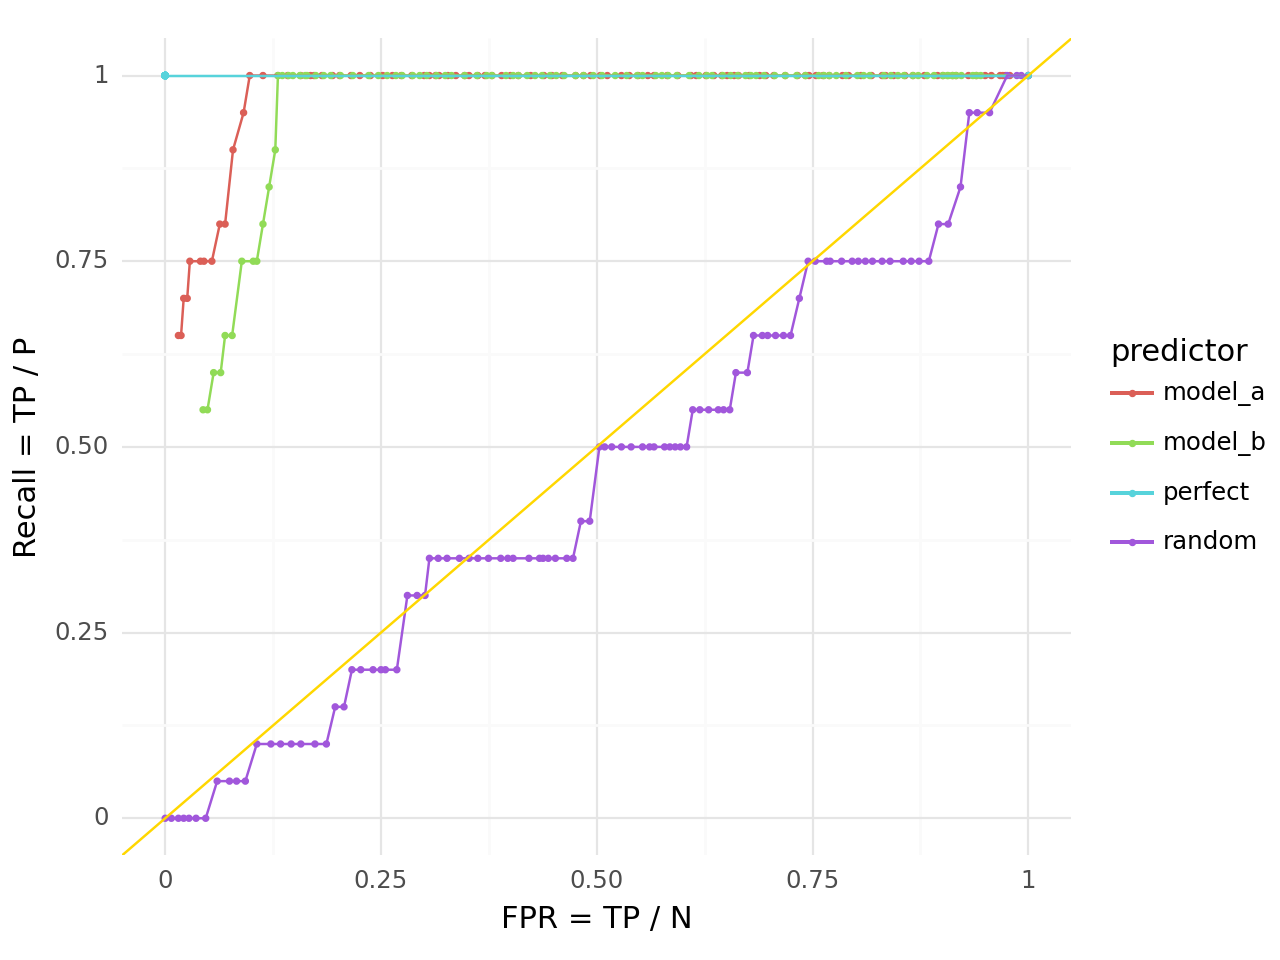

<Figure Size: (640 x 480)>

In [192]:
model_a_roc = roc_curve_coordinates(
    df.actual,
    df.model_a_prob
)
model_a_roc['predictor'] = 'model_a'
model_b_roc = roc_curve_coordinates(
    df.actual,
    df.model_b_prob
)
model_b_roc['predictor'] = 'model_b'
random_roc = roc_curve_coordinates(
    df.actual,
    df.random_prob
)
random_roc['predictor'] = 'random'
perfect_roc = roc_curve_coordinates(
    df.actual,
    df.actual
)
perfect_roc['predictor'] = 'perfect'

plot_df = pd.concat([model_a_roc,model_b_roc,random_roc,perfect_roc],axis=0).reset_index(drop=True)
g = (ggplot(plot_df, aes(x='fpr',y='recall',color='predictor'))+
     geom_point(size=0.5) + geom_line() +
     geom_abline(slope=1, intercept = 0, color='gold') +
     ylab('Recall = TP / P') + xlab('FPR = TP / N')
)
g

เริ่มจากลองเปรียบเทียบ metric ที่เราคุ้นเคยอย่าง AUROC จะเห็นว่า AUROC ของ Model A สูงกว่า Model B ในระดับพอๆกัน (0.97 vs 0.94 และ 0.99 vs 0.97) ไม่ว่าชุดข้อมูลจะมี positive 2% หรือ 50%
เพราะฉะนั้น อย่างน้อย AUROC ยังสามารถบอกได้ว่าโมเดลไหนดีกว่ากัน ไม่ว่า prevalence จะมากหรือน้อยแค่ไหน



In [193]:
#AUROC ของโมเดลที่ดีกว่า (Model A) มีค่าสูงกว่าเป็นปกติต่อให้ prevalence เป็น 2%
roc_auc_score(df.actual, df.model_a_prob),\
roc_auc_score(df.actual, df.model_b_prob)

(0.9728316326530612, 0.9435459183673469)

In [194]:
num_samples = 1000

np.random.seed(125)
actual_probabilities = np.random.uniform(0, 1, size=num_samples)
np.random.seed(126)
predicted_a_probabilities = (actual_probabilities + np.random.uniform(-0.1, 0.1, size=num_samples)).clip(0,1)
np.random.seed(127)
predicted_b_probabilities = (actual_probabilities + np.random.uniform(-0.2, 0.2, size=num_samples)).clip(0,1)
np.random.seed(128)
random_probabilities = np.random.uniform(0, 1, size=num_samples)

#prevalence 50/50
actuals = (actual_probabilities > 0.5).astype(int)

df_50_50 = pd.DataFrame({
    'actual': actuals,
    'random_prob': random_probabilities,
    'model_a_prob': predicted_a_probabilities,
    'model_b_prob': predicted_b_probabilities
})

#ผลไม่ต่างกัน
roc_auc_score(df_50_50.actual, df_50_50.model_a_prob),\
roc_auc_score(df_50_50.actual, df_50_50.model_b_prob)

(0.9930439588163917, 0.9704738677911666)

In [195]:
#จริงๆ scikit-learn ก็มีฟังก์ชันพลอต precision-recall curve ให้เราใช้สำเร็จรูปชื่อ precision_recall_curve
from sklearn.metrics import precision_recall_curve

def precision_recall_curve_coordinates(actual,
                                       prob,
                                       cutoffs=[i/100 for i in range(101)]):
    precision = np.zeros(len(cutoffs))
    recall = np.zeros(len(cutoffs))

    for i, cutoff in enumerate(cutoffs):
        pred = (prob >= cutoff).astype(int)
        tp = np.sum((pred == 1) & (actual == 1))
        fp = np.sum((pred == 1) & (actual == 0))
        fn = np.sum((pred == 0) & (actual == 1))

        precision[i] = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall[i] = tp / (tp + fn) if (tp + fn) > 0 else 0.0

    return pd.DataFrame({
        'precision': np.append(precision,1),
        'recall': np.append(recall,0),
        'cutoff': cutoffs+[1]
    })


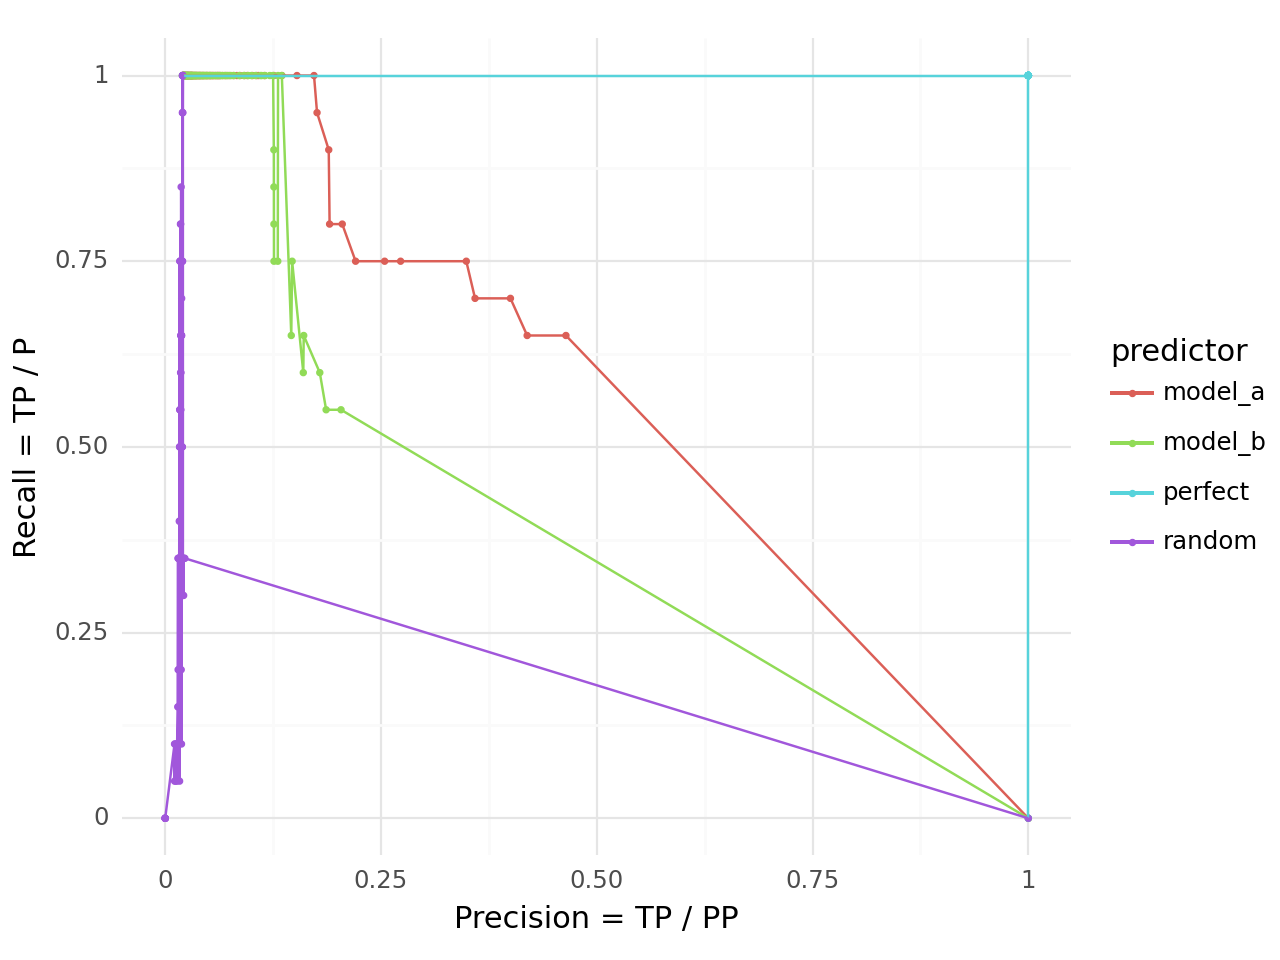

<Figure Size: (640 x 480)>

In [196]:
model_a_pr = precision_recall_curve_coordinates(
    df.actual,
    df.model_a_prob
)
model_a_pr['predictor'] = 'model_a'
model_b_pr = precision_recall_curve_coordinates(
    df.actual,
    df.model_b_prob
)
model_b_pr['predictor'] = 'model_b'
perfect_pr = precision_recall_curve_coordinates(
    df.actual,
    df.actual
)
perfect_pr['predictor'] = 'perfect'
random_pr = precision_recall_curve_coordinates(
    df.actual,
    df.random_prob
)
random_pr['predictor'] = 'random'

plot_df = pd.concat([model_a_pr,model_b_pr,perfect_pr,random_pr],axis=0).reset_index(drop=True)
g = (ggplot(plot_df, aes(x='precision',y='recall',color='predictor'))+
     geom_point(size=0.5) + geom_line() +
    #  geom_text(aes(x='precision+0.05',y='recall+0.05',label='cutoff'))+
     ylab('Recall = TP / P') + xlab('Precision = TP / PP')
)
g

precision-recall curve อยู่บนแกน
* X = Precision; จากตัวอย่างที่โมเดลทายว่า positive ทั้งหมด โมเดลทายถูกว่าเป็น positive กี่ %
* Y = Recall; จากตัวอย่างที่ positive (`1`) จริงๆทั้งหมด โมเดลทายถูกว่าเป็น positive (`1`) กี่ %

โดยที่แต่ละจุดคือพิกัด `(Precision, Recall)` ที่คำนวณจากการให้โมเดลทำนาย positive (`1`) หาก predicted probability สูงกว่าค่าใดค่าหนึ่ง (นิยมเรียกว่า cutoff หรือ threshold) โดยทั่วไปอาจจะไล่พลอตจาก 0.01, 0.02, ... 1.00 แล้วเชื่อมทุกจุดเข้ากันเป็นเส้น

พื้นที่ใต้เส้นโค้ง precision-recall มีค่าระหว่าง 0 ถึง 1 (ยิ่งสูงยิ่งดี)

ในทำนองเดียวกับ AUROC คำอธิบายแบบง่ายๆว่าทำไมพื้นที่ใต้พลอต precision-recall curve นี้ยิ่งสูงยิ่งดีคือ หาก cutoff สูงขึ้น โมเดลจะมี precision สูงขึ้นแต่ recall ต่ำลง เนื่องจากมันจะทายว่า positive ได้ยากขึ้น (ต้องทายด้วย predicted probability สูงขึ้น) เราอยากให้ precision สูงขึ้นด้วยอัตราความเร็วที่สูงกว่า recall ลดลง (เพราะทั้งสองค่ายิ่งสูงยิ่งดี)

In [197]:
#ลองดูเองว่า cutoff สูงขึ้น-ต่ำลง recall, precision จะเปลี่ยนไปยังไง
from sklearn.metrics import recall_score, precision_score

cutoff = 0.90
print(f'''
cutoff: {cutoff}
recall: {recall_score(df.actual, (df.model_a_prob>cutoff).astype(int))}
precision: {precision_score(df.actual, (df.model_a_prob>cutoff).astype(int))}
''')

cutoff = 0.95
print(f'''
cutoff: {cutoff}
recall: {recall_score(df.actual, (df.model_a_prob>cutoff).astype(int))}
precision: {precision_score(df.actual, (df.model_a_prob>cutoff).astype(int))}
''')


cutoff: 0.9
recall: 0.9
precision: 0.18947368421052632


cutoff: 0.95
recall: 0.75
precision: 0.2727272727272727



ทีนี้ลองกลับมาเปรียบเทียบกรณีที่ชุดข้อมูล balanced และ imbalanced กัน จะเห็นได้ว่าในชุดข้อมูลที่ prevalence เป็น 2% (imbalanced) ความต่างระหว่าง AUPRC จะชัดเจนกว่า AUROC มาก (0.39 vs 0.18 กับ 0.99 vs 0.97) แต่สุดท้ายแล้วทั้งสองค่าก็บอกเราได้อย่างถูกต้องว่า Model A ดีกว่า Model B

In [198]:
#ฟังก์ชันคำนวณ AUPRC ใน sklearn เรียกว่า average_precision_score
from sklearn.metrics import average_precision_score

#กรณี prevalence 2%
average_precision_score(df.actual, df.model_a_prob), \
average_precision_score(df.actual, df.model_b_prob),

(0.38870795287161786, 0.1784838127708595)

In [199]:
#กรณี prevalence 50%
average_precision_score(df_50_50.actual, df_50_50.model_a_prob), \
average_precision_score(df_50_50.actual, df_50_50.model_b_prob)

(0.9936875227039582, 0.9737079953744825)

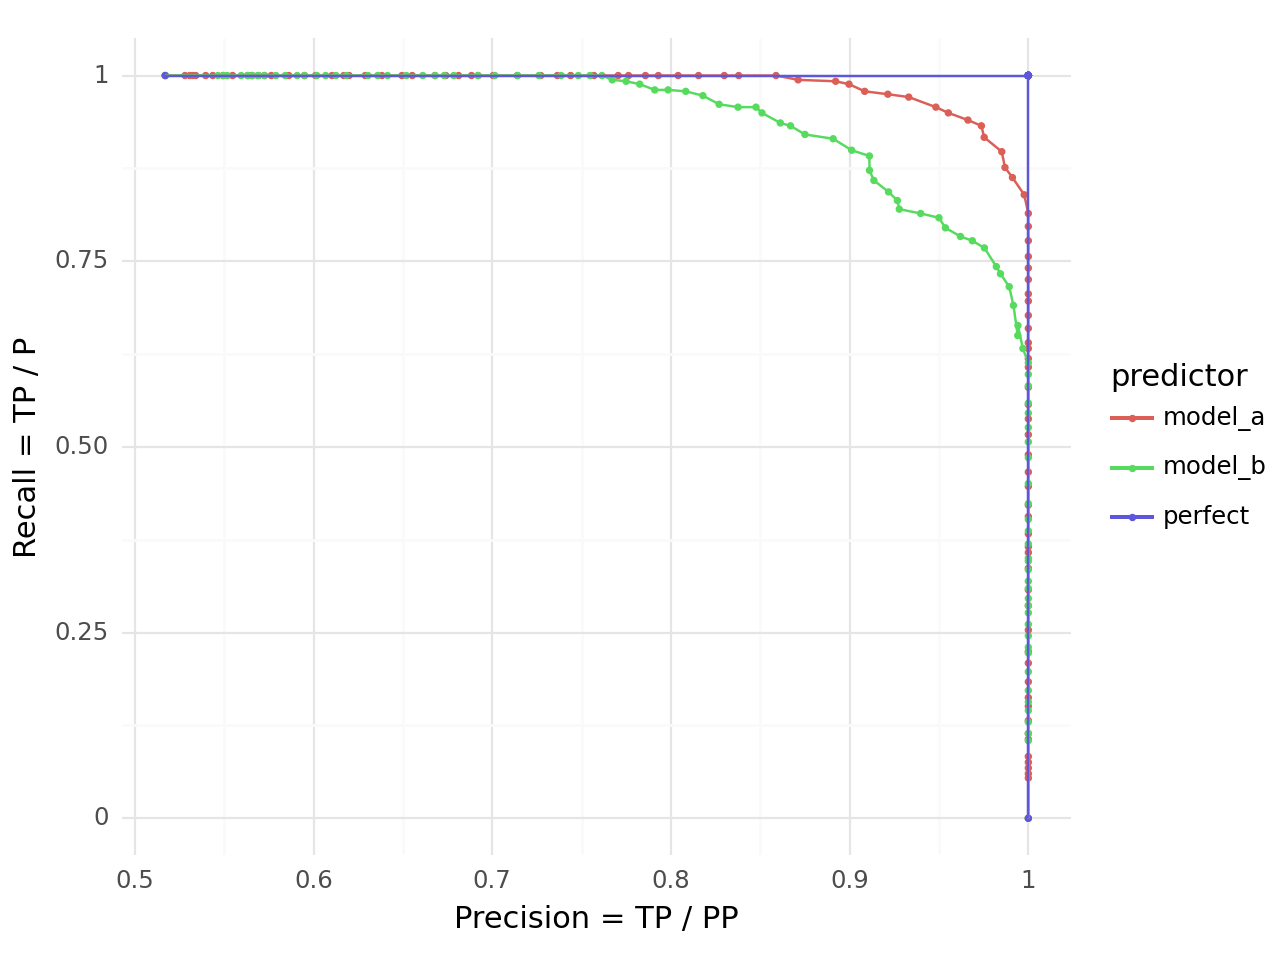

<Figure Size: (640 x 480)>

In [200]:
#precision-recall curve เมื่อ prevalence 50% จะเห็นได้ว่าพลอตมันดูใกล้เคียงกันกว่า
model_a_pr = precision_recall_curve_coordinates(
    df_50_50.actual,
    df_50_50.model_a_prob
)
model_a_pr['predictor'] = 'model_a'
model_b_pr = precision_recall_curve_coordinates(
    df_50_50.actual,
    df_50_50.model_b_prob
)
model_b_pr['predictor'] = 'model_b'
perfect_pr = precision_recall_curve_coordinates(
    df_50_50.actual,
    df_50_50.actual
)
perfect_pr['predictor'] = 'perfect'

plot_df = pd.concat([model_a_pr,model_b_pr,perfect_pr],axis=0).reset_index(drop=True)
g = (ggplot(plot_df, aes(x='precision',y='recall',color='predictor'))+
     geom_point(size=0.5) + geom_line() +
     ylab('Recall = TP / P') + xlab('Precision = TP / PP')
)
g

ความแตกต่างที่ชัดเจนกว่าของ AUPRC เมื่อเทียบกับ AUROC นี้เกิดจากพฤติกรรมของ precision-recall curve ที่อ่อนไหวต่อ **ตัวอย่างที่โมเดลแน่ใจสูง** (มี predicted probabilities สูง)

อย่าลืมว่าชุดข้อมูลตัวอย่างของเราถูกสร้างโดยการให้ตัวอย่างที่มี true probability > 0.98 เป็น positive และในเมื่อ "โมเดล" ของเราสร้างมาจาก true probability +/- ค่าบางอย่าง ทำให้ตัวอย่าง positive เป็น **ตัวอย่างที่โมเดลแน่ใจสูง** ตามเงื่อนไขไปโดยปริยาย

In [201]:
num_samples = 1000

np.random.seed(125)
actual_probabilities = np.random.uniform(0, 1, size=num_samples)
np.random.seed(126)
predicted_a_probabilities = (actual_probabilities + np.random.uniform(-0.1, 0.1, size=num_samples)).clip(0,1)
np.random.seed(127)
predicted_b_probabilities = (actual_probabilities + np.random.uniform(-0.2, 0.2, size=num_samples)).clip(0,1)
np.random.seed(128)
random_probabilities = np.random.uniform(0, 1, size=num_samples)

#แทนที่จะ >0.5 เป็น >0.98
actuals = (actual_probabilities > 0.98).astype(int)

df = pd.DataFrame({
    'actual': actuals,
    'true_prob': actual_probabilities,
    'random_prob': random_probabilities,
    'model_a_prob': predicted_a_probabilities,
    'model_b_prob': predicted_b_probabilities
})
df

,actual,true_prob,random_prob,model_a_prob,model_b_prob
0,0,0.506726,0.866637,0.427760,0.516259
1,0,0.057531,0.263145,0.000000,0.000000
2,0,0.627580,0.131408,0.545061,0.501966
3,0,0.132553,0.041593,0.055648,0.241669
4,0,0.131085,0.238924,0.180631,0.151945
...,...,...,...,...,...
995,0,0.660039,0.927722,0.590691,0.615220
996,0,0.920005,0.884416,0.849234,0.801212
997,0,0.315999,0.646896,0.362357,0.259718
998,0,0.484264,0.184905,0.441201,0.290565


เราจะเห็นสิ่งนี้อย่างชัดเจนเมื่อดู precision-recall curve ของชุดข้อมูล prevalence 2% และพบว่าการลดลงของ recall เมื่อ cutoff > 0.9 ขึ้นไปนั้นส่งผลให้พื้นที่ใต้พลอตลดลงอย่างมาก การที่ recall เพิ่งมาเริ่มลดตอน cutoff สูงเกือบ 0.9 นี้ชี้ให้เห็นว่าตัวอย่าง positive ส่วนใหญ่ถูกโมเดลทายด้วย predicted probability ที่สูงเกือบ 0.9 ขึ้นไปเช่นกัน

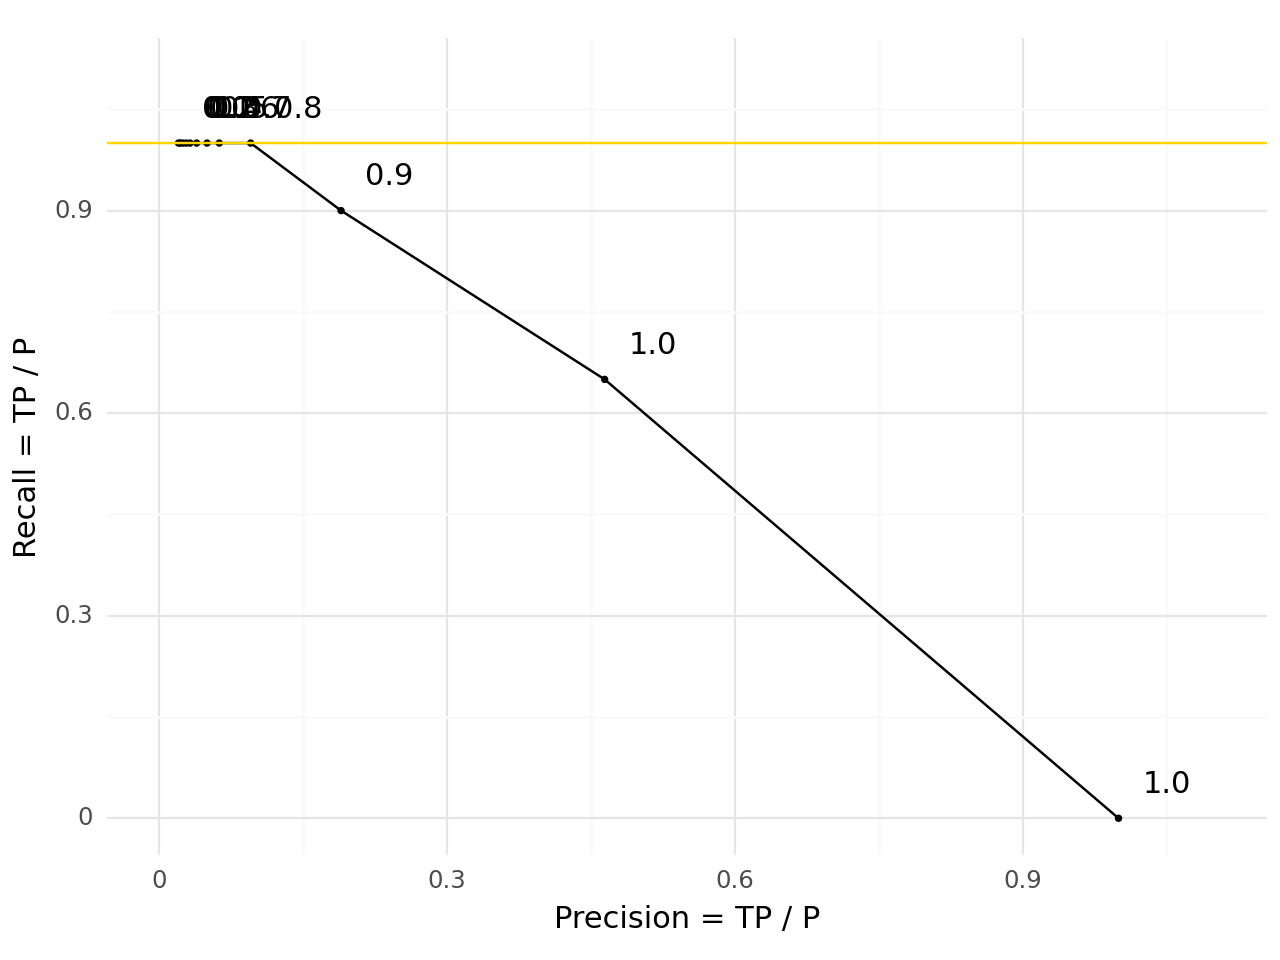

<Figure Size: (640 x 480)>

In [202]:
model_pr = precision_recall_curve_coordinates(
    df.actual,
    df.model_a_prob,
    cutoffs=[i/10 for i in range(11)])


g = (ggplot(model_pr, aes(x='precision',y='recall'))+
     geom_point(size=0.5) + geom_line() + expand_limits(x = [0,1.1], y = [0,1.1]) +
     geom_abline(slope=0, intercept = 1, color='gold') +
     geom_text(aes(x='precision+0.05',y='recall+0.05',label='cutoff'))+
     ylab('Recall = TP / P') + xlab('Precision = TP / P')
)
g

ยิ่งเทียบกับ precision-recall curve ของชุดข้อมูล prevalence 50% ยิ่งชัดเจนเนื่องจาก recall เริ่มลดตั้งแต่ cutoff > 0.4 แสดงให้เห็นว่าโมเดลทายตัวอย่าง positive ด้วย predicted probabilities ตั้งแต่ > 0.4 ขึ้นไป

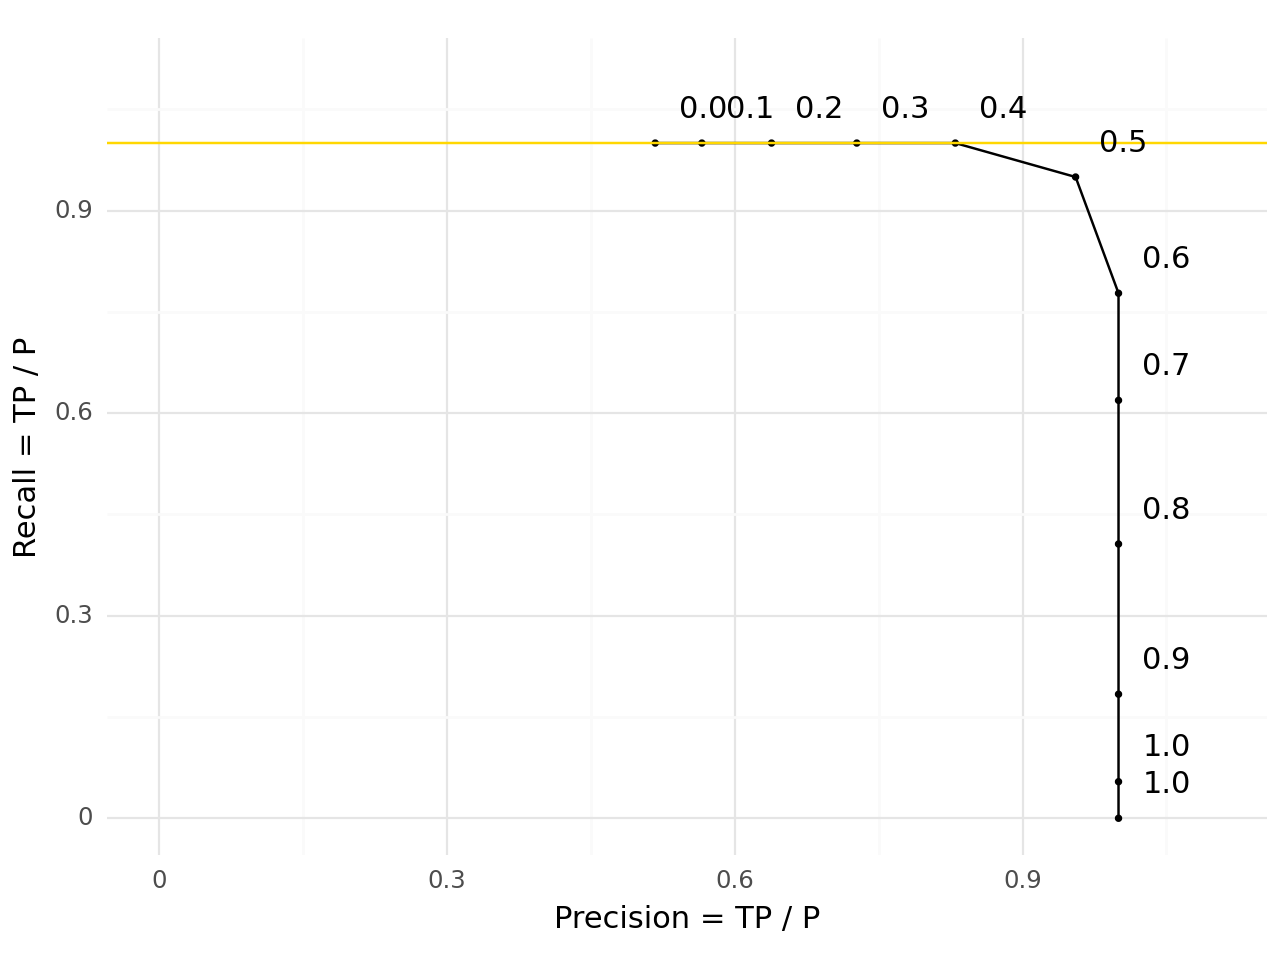

<Figure Size: (640 x 480)>

In [203]:
model_pr = precision_recall_curve_coordinates(
    df_50_50.actual,
    df_50_50.model_a_prob,
    cutoffs=[i/10 for i in range(11)])


g = (ggplot(model_pr, aes(x='precision',y='recall'))+
     geom_point(size=0.5) + geom_line() + expand_limits(x = [0,1.1], y = [0,1.1]) +
     geom_abline(slope=0, intercept = 1, color='gold') +
     geom_text(aes(x='precision+0.05',y='recall+0.05',label='cutoff'))+
     ylab('Recall = TP / P') + xlab('Precision = TP / P')
)
g

เราสามารถตรวจสอบในชุดข้อมูลได้ง่ายๆด้วยการเรียกดูสรุปข้อมูล

In [204]:
df.groupby('actual').model_a_prob.describe()

,count,mean,std,min,25%,50%,75%,max
actual,,,,,,,,
0,980.0,0.501258,0.283141,0.000000,0.255149,0.504147,0.751577,1.0
1,20.0,0.973013,0.043640,0.886061,0.954680,1.000000,1.000000,1.0


In [205]:
df_50_50.groupby('actual').model_a_prob.describe()

,count,mean,std,min,25%,50%,75%,max
actual,,,,,,,,
0,483.0,0.257491,0.150239,0.000000,0.131535,0.250157,0.383338,0.578847
1,517.0,0.747244,0.153188,0.425333,0.612766,0.758273,0.871003,1.000000


สรุปสั้นๆคือ AUPRC ให้ความสำคัญกับตัวอย่างที่มี predicted probability สูงกว่า ในขณะที่ AUROC ให้ความสำคัญกับทุกตัวอย่างเท่าๆกัน เหตุที่คนสับสบว่า AUPRC ดีกว่าสำหรับ label imbalance นั้นก็เพราะหลายครั้งในโลกแห่งความเป็นจริง โมเดลจะทำนายตัวอย่างที่มี label หายากด้วย predicted probability สูงนั่นเอง

เราสามารถแสดงให้เห็นได้ด้วยซ้ำว่า ต่อให้ชุดข้อมูลมี prevalence ที่ต่ำมากๆ (เกิด label imbalance) ก็มีกรณีที่ AUPRC ไม่ได้ต่างกันขนาดนั้นสำหรับโมเดลที่ประสิทธิผลต่างกัน

In [206]:
num_samples = 1000

np.random.seed(125)
actual_probabilities = np.random.uniform(0, 1, size=num_samples)
np.random.seed(126)
predicted_a_probabilities = (actual_probabilities + np.random.uniform(-0.1, 0.1, size=num_samples)).clip(0,1)
np.random.seed(127)
predicted_b_probabilities = (actual_probabilities + np.random.uniform(-0.2, 0.2, size=num_samples)).clip(0,1)
np.random.seed(128)
random_probabilities = np.random.uniform(0, 1, size=num_samples)

actuals = (
    (actual_probabilities > 0.7)&(actual_probabilities < 0.71)|\
    (actual_probabilities > 0.8)&(actual_probabilities < 0.81)|\
    (actual_probabilities > 0.9)&(actual_probabilities < 0.91)).astype(int)

df_difficult_positive = pd.DataFrame({
    'actual': actuals,
    'true_prob': actual_probabilities,
    'random_prob': random_probabilities,
    'model_a_prob': predicted_a_probabilities,
    'model_b_prob': predicted_b_probabilities
})

#การกระจายตัวของ predicted probability สำหรับตัวอย่าง positive มีตั้งแต่ 0.71 ถึง 1
df_difficult_positive.groupby('actual').model_a_prob.describe()

,count,mean,std,min,25%,50%,75%,max
actual,,,,,,,,
0,976.0,0.502567,0.286485,0.000000,0.254680,0.501622,0.753757,1.0
1,24.0,0.841134,0.087621,0.710676,0.768134,0.843430,0.909125,1.0


In [207]:
#ต่อให้ prevalence 2% เหมือนกัน
#แต่หากโมเดลไม่ได้ทำนายตัวอย่าง positive ด้วย predicted probability ที่สูงทั้งหมด
#AUPRC ก็ไม่ได้ต่างกันเว่อร์ขนาดนั้น
df_difficult_positive.actual.mean()

0.024

In [208]:
#prevalence 2%; predicted probability ของตัวอย่าง positive หลากหลาย
#ประสิทธิผลโมเดล A>B

print(f'''
AUROC
Model A: {roc_auc_score(df_difficult_positive.actual, df_difficult_positive.model_a_prob)}
Model B: {roc_auc_score(df_difficult_positive.actual, df_difficult_positive.model_b_prob)}

AUPRC
Model A: {average_precision_score(df_difficult_positive.actual, df_difficult_positive.model_a_prob)}
Model B: {average_precision_score(df_difficult_positive.actual, df_difficult_positive.model_b_prob)}
''')


AUROC
Model A: 0.8393741461748635
Model B: 0.8346140710382514

AUPRC
Model A: 0.07189337718071921
Model B: 0.07161119032297586



In [209]:
#prevalence 2%; predicted probability ของตัวอย่าง positive สูงเป็นส่วนใหญ่
#ประสิทธิผลโมเดล A>B

print(f'''
AUROC
Model A: {roc_auc_score(df.actual, df.model_a_prob)}
Model B: {roc_auc_score(df.actual, df.model_b_prob)}

AUPRC
Model A: {average_precision_score(df.actual, df.model_a_prob)}
Model B: {average_precision_score(df.actual, df.model_b_prob)}
''')


AUROC
Model A: 0.9728316326530612
Model B: 0.9435459183673469

AUPRC
Model A: 0.38870795287161786
Model B: 0.1784838127708595



## Information Retrieval

ML model ในชีวิตจริงส่วนใหญ่สร้างมาเพื่อแก้ปัญหาการจัดลำดับ เช่น search (แสดงผลการค้นหา X ลำดับแรกที่ตรงกับคำค้นหาของผู้ใช้) และ recommendation (แนะนำสิ่งของ X ลำดับที่ผู้ใช้ต้องการ) เราสามารถวัดผลการเรียงลำดับนี้ได้ด้วย metric หลากหลายรูปแบบ ในบทเรียนนี้เราจะแนะนำ metric อันเป็นที่นิยมและนำไปใช้งานได้สะดวกคือ precision/recall at k, mean average precision (mAP) และ mean reciprocal rank (MRR)

เราจะมาเรียนรู้การคำนวณ metric แต่ละอันผ่านตัวอย่างชุดข้อมูลการเสนอแนะอนิเมะให้คนดู มีแต่ละคอลัมน์ดังนี้:

1. `user_id`: เลขประจำตัวผู้ใช้
2. `anime_id`: เลขประจำอนิเมะ
3. `predicted_probability`: คะแนนที่โมเดลคาดหวังว่า `user_id` นี้จะดู `anime_id`
4. `watched`: เมื่อโมเดลเสนอ `anime_id` ไปแล้ว `user_id` ได้ดูหรือไม่ (1 หรือ 0)

In [210]:
import numpy as np


anime_names = [
    "Attack on Titan",
    "One Piece",
    "Naruto",
    "Death Note",
    "Fullmetal Alchemist: Brotherhood",
    "Sword Art Online",
    "My Hero Academia",
    "Tokyo Ghoul",
    "Hunter x Hunter",
    "Dragon Ball Z",
    "Cowboy Bebop",
    "Steins;Gate",
    "Neon Genesis Evangelion",
    "Fairy Tail",
    "Demon Slayer: Kimetsu no Yaiba",
    "Code Geass",
    "One Punch Man",
    "Bleach",
    "The Promised Neverland",
    "Black Clover"
]

#ชุดข้อมูลคนดูอนิเมะ 50 คน มีอนิเมะ 20 เรื่อง
num_users = 50
num_anime_items = 20

#สร้าง predicted probabilty ระหว่าง 0 ถึง 1
#เป็น matrix ขนาด num_users x num_anime_items
#เช่น user_item_prob[i,j] คือ predicted probability ที่ user i จะเลือกดู anime_item j เมื่อเห็น
np.random.seed(0)
user_item_prob = np.random.randint(0, 101, size=(num_users, num_anime_items))/101

outcome = np.zeros((num_users, num_anime_items))
#สร้าง outcome ว่า user จะดูหรือไม่ดู anime เมื่อเห็น ในรูปแบบ matrix เช่นเดียวกับ user_item_prob
np.random.seed(11)
num_watched_items = np.random.randint(1, 10, size=num_users)
for i in range(num_users):
    watched_indices = np.random.choice(num_anime_items, size=num_watched_items[i], replace=False)
    outcome[i, watched_indices] = 1

user_item_prob.shape, outcome.shape

((50, 20), (50, 20))

In [211]:
user_item_prob[:3,:3]

array([[0.43564356, 0.46534653, 0.63366337],
       [0.8019802 , 0.36633663, 0.24752475],
       [0.38613861, 0.31683168, 0.64356436]])

In [212]:
outcome[:3,:3]

array([[0., 0., 0.],
       [0., 0., 0.],
       [1., 0., 1.]])

In [213]:
#เปลี่ยนรูปแบบ matrix เป็น dataframe เพื่อให้ดูง่าย
ds = []
for user_id in range(num_users):
    for anime_id in range(num_anime_items):
        predicted_probability = user_item_prob[user_id][anime_id]
        watched = outcome[user_id][anime_id]
        ds.append({
            'user_id': user_id,
            'anime_id': anime_id,
            'anime_name': anime_names[anime_id],
            'predicted_probability': predicted_probability,
            'watched': watched
        })

df = pd.DataFrame(ds)
df.head()

,user_id,anime_id,anime_name,predicted_probability,watched
0,0,0,Attack on Titan,0.435644,0.0
1,0,1,One Piece,0.465347,0.0
2,0,2,Naruto,0.633663,0.0
3,0,3,Death Note,0.663366,0.0
4,0,4,Fullmetal Alchemist: Brotherhood,0.663366,0.0


In [214]:
#แต่ละ user_id จะมี predicted probability และ outcome (watch) ของ anime ทั้ง 20 เรื่อง
df.groupby(['user_id'])[['predicted_probability','watched']].agg(['count','mean'])

predicted_probability           watched      
                        count      mean   count  mean
user_id                                              
0                          20  0.577228      20  0.05
1                          20  0.524257      20  0.10
2                          20  0.356931      20  0.40
3                          20  0.414851      20  0.10
4                          20  0.540099      20  0.40
5                          20  0.527723      20  0.15
6                          20  0.509406      20  0.45
7                          20  0.388119      20  0.05
8                          20  0.487624      20  0.05
9                          20  0.512871      20  0.25
10                         20  0.510396      20  0.15
11                         20  0.454455      20  0.10
12                         20  0.456931      20  0.30
13                         20  0.409406      20  0.30
14                         20  0.454455      20  0.40
15                         20  0.476238      20  0.25
16                         20  0.604950      20  0.10
17                         20  0.573267      20  0.45
18                         20  0.505446      20  0.45
19                         20  0.450000      20  0.10
20                         20  0.533168      20  0.20
21                         20  0.501485      20  0.35
22                         20  0.435644      20  0.15
23                         20  0.421287      20  0.15
24                         20  0.550000      20  0.05
25                         20  0.466337      20  0.05
26                         20  0.589604      20  0.40
27                         20  0.562376      20  0.35
28                         20  0.542574      20  0.30
29                         20  0.601485      20  0.40
30                         20  0.437129      20  0.40
31                         20  0.646040      20  0.05
32                         20  0.491089      20  0.45
33                         20  0.489604      20  0.05
34                         20  0.544554      20  0.45
35                         20  0.459406      20  0.30
36                         20  0.489604      20  0.30
37                         20  0.449505      20  0.40
38                         20  0.501980      20  0.15
39                         20  0.479208      20  0.20
40                         20  0.500495      20  0.10
41                         20  0.285149      20  0.05
42                         20  0.566337      20  0.20
43                         20  0.475248      20  0.45
44                         20  0.469307      20  0.40
45                         20  0.519307      20  0.10
46                         20  0.523762      20  0.25
47                         20  0.412376      20  0.45
48                         20  0.607426      20  0.15
49                         20  0.530693      20  0.05

### User-level Accuracy at k

หากโมเดลเราแนะนำ item ที่มี predicted probability มากที่สุด k อันให้ user แล้วมี item อันในอันหนึ่งเป็น item ที่ถูกต้อง (relevant) ให้ 1 คะแนน ถ้าไม่มีเลยให้ 0 คะแนน ค่าเฉลี่ยของคะแนนเหล่านี้คือ user-level accuracy at k

Metric นี้เป็นอันที่คำนวณง่ายที่สุดสำหรับปัญหา information retrieval อีกทั้งยังใกล้เคียงกับการใช้งานจริงอีกด้วย เช่น หลายครั้งเวลาเราแนะนำสินค้า โฆษณา หรือบทความให้ user เราอยากคำนวณว่า user ได้เลือกคลิกอันใดอันหนึ่งหรือเปล่า (เรียกว่า click-through rate)

In [215]:
#เรียงลำดับ anime ในแต่ละ user ด้วย predicted_probability จากมากไปน้อย
df_sorted = df.sort_values(['user_id','predicted_probability','anime_id'], ascending=[True,False,True])

#สร้างลำดับการแนะนำ anime ให้แต่ละ user
df_sorted['rnk'] = df_sorted.groupby('user_id').cumcount()
df_sorted

,user_id,anime_id,anime_name,predicted_probability,watched,rnk
11,0,11,Steins;Gate,0.871287,0.0,0
12,0,12,Neon Genesis Evangelion,0.871287,0.0,1
19,0,19,Black Clover,0.871287,0.0,2
9,0,9,Dragon Ball Z,0.861386,0.0,3
17,0,17,Bleach,0.861386,0.0,4
...,...,...,...,...,...,...
990,49,10,Cowboy Bebop,0.257426,0.0,15
984,49,4,Fullmetal Alchemist: Brotherhood,0.227723,1.0,16
997,49,17,Bleach,0.168317,0.0,17
993,49,13,Fairy Tail,0.059406,0.0,18


In [216]:
%%time
#คำนวณ user-level accuracy at 5
df_sorted[df_sorted.rnk<5].groupby('user_id').watched.max().mean()

CPU times: user 2.75 ms, sys: 0 ns, total: 2.75 ms
Wall time: 3.14 ms


0.68

In [217]:
%%time
#คำนวณจากข้อมูลในรูปแบบ matrix มันเร็วกว่า
def top_k_accuracy(y_true, y_score, k=5):
    top_k_preds = np.argsort(-y_score, axis=1)[:, :k]
    any_correct = np.max(y_true[np.arange(len(y_true))[:, None], top_k_preds], axis=1)
    top_k_acc = np.mean(any_correct)
    return top_k_acc

top_k_accuracy(outcome, user_item_prob, k=5)

CPU times: user 265 µs, sys: 28 µs, total: 293 µs
Wall time: 302 µs


0.68

### Precision/Recall at k

Precision at k ประเมินว่าใน item ที่จัดลำดับ 1 ถึง k (อาจจะ 1-3, 1-5, ...) ด้วย predicted probability ให้ user แต่ละคนนั้น มี item ที่ถูกต้อง (relevant) กี่อันจาก top-k item ทั้งหมด นิยมใช้ในกรณีที่เรารู้ว่าเราแนะนำ item ได้ k อันแล้วอยากรู้ว่าตรงใจ user กี่อัน เช่น เว็บไซต์เรามีช่องแนะนำสินค้า 4 ช่อง คนจะกดดู-ซื้อกี่อัน เราอาจจะสนใจ Precision@4 เป็นต้น

`Precision at k ของแต่ละ user = จำนวน item ใน top-k ที่ทายถูก / จำนวน item ที่ทายว่าเป็น top-k ทั้งหมด`

Recall at k ประเมินว่าจาก item ที่ถูกต้องถูกรวมอยู่ในคำทำนายลำดับที่ 1 ถึง k กี่อัน

`Recall at k ของแต่ละ user = จำนวน item ใน top-k ที่ทายถูก / จำนวน item ที่ถูกต้องจริงๆทั้งหมด`

จะเห็นได้ว่าเช่นเดียวกับปัญหา classification เราจะเลือกใช้ precision@k ในกรณีที่เราอยากให้ item ส่วนใหญ่ที่โมเดลเราเลือกมาถูก และ recall@k ในกรณีที่เราอยากให้โมเดลเลือก item ที่ถูกต้องมาให้มากที่สุดเท่าที่จะทำได้

In [218]:
#เรียงลำดับ anime ในแต่ละ user ด้วย predicted_probability จากมากไปน้อย
df_sorted = df.sort_values(['user_id','predicted_probability','anime_id'], ascending=[True,False,True])

#สร้างลำดับการแนะนำ anime ให้แต่ละ user
df_sorted['rnk'] = df_sorted.groupby('user_id').cumcount()
df_sorted

,user_id,anime_id,anime_name,predicted_probability,watched,rnk
11,0,11,Steins;Gate,0.871287,0.0,0
12,0,12,Neon Genesis Evangelion,0.871287,0.0,1
19,0,19,Black Clover,0.871287,0.0,2
9,0,9,Dragon Ball Z,0.861386,0.0,3
17,0,17,Bleach,0.861386,0.0,4
...,...,...,...,...,...,...
990,49,10,Cowboy Bebop,0.257426,0.0,15
984,49,4,Fullmetal Alchemist: Brotherhood,0.227723,1.0,16
997,49,17,Bleach,0.168317,0.0,17
993,49,13,Fairy Tail,0.059406,0.0,18


In [219]:
df_sorted[df_sorted.user_id==5]

,user_id,anime_id,anime_name,predicted_probability,watched,rnk
116,5,16,One Punch Man,0.970297,1.0,0
106,5,6,My Hero Academia,0.940594,0.0,1
108,5,8,Hunter x Hunter,0.930693,0.0,2
114,5,14,Demon Slayer: Kimetsu no Yaiba,0.920792,0.0,3
118,5,18,The Promised Neverland,0.762376,0.0,4
102,5,2,Naruto,0.683168,0.0,5
107,5,7,Tokyo Ghoul,0.683168,0.0,6
105,5,5,Sword Art Online,0.633663,0.0,7
110,5,10,Cowboy Bebop,0.495050,0.0,8
101,5,1,One Piece,0.485149,1.0,9


In [220]:
%%time
#precision@5 ของ user_id == 5
k = 5
df_sorted[(df_sorted.user_id==5)&(df_sorted.rnk<k)].watched.mean()

CPU times: user 1.9 ms, sys: 0 ns, total: 1.9 ms
Wall time: 1.93 ms


0.2

In [221]:
%%time
#average precision@5 ของ user ทุกคน
df_sorted[(df_sorted.rnk<k)].groupby('user_id').watched.mean().mean()

CPU times: user 2.97 ms, sys: 0 ns, total: 2.97 ms
Wall time: 2.95 ms


0.23600000000000002

In [222]:
def precision_at_k(y_true, y_score, k=5):
    top_k_preds = np.argsort(-y_score, axis=1)[:, :k]
    correct_preds = np.sum(y_true[np.arange(len(y_true))[:, None], top_k_preds], axis=1)
    precision = np.mean(correct_preds / k)
    return precision

In [223]:
#คำนวณจากข้อมูลในรูปแบบ matrix มันเร็วกว่า
#precision@5 ของ user_id == 5
%%time
precision_at_k(outcome[5,:][None,:], user_item_prob[5,:][None,:], k=5)

CPU times: user 239 µs, sys: 0 ns, total: 239 µs
Wall time: 245 µs


0.2

In [224]:
%%time
#คำนวณจากข้อมูลในรูปแบบ matrix มันเร็วกว่า
#average precision@5 ของ user ทุกคน
precision_at_k(outcome, user_item_prob, k=5)

CPU times: user 0 ns, sys: 433 µs, total: 433 µs
Wall time: 443 µs


0.23600000000000002

### Average Precision (AP) and Mean Average Precision (mAP)

หากเรารู้ว่า k ของเราควรจะเป็นเท่าไหร่ เช่น เว็บไซต์มีช่องให้แสดงสินค้าแค่ 5 ช่องจึงใช้ k=5 เราสามารถใช้ user-level accuracy/precision/recall@k อย่างไม่ต้องกังวล แต่หากเราต้องการวัดผลโมเดลของเราโดยทั่วไปโดยไม่กำหนด k เราจะทำอย่างไร?

ลองมาดู `user_id==5` ในแต่ละ precision at k ตั้งแต่ 1 ถึง 10 กัน เราจะเห็นได้ว่ายิ่งทายเยอะ (k สูง) precision ก็จะยิ่งต่ำลงเป็นปกติ

In [225]:
for i in range(1,11):
    print(f'Precision@{i}: {precision_at_k(outcome[5,:][None,:], user_item_prob[5,:][None,:], k=i)}')

Precision@1: 1.0
Precision@2: 0.5
Precision@3: 0.3333333333333333
Precision@4: 0.25
Precision@5: 0.2
Precision@6: 0.16666666666666666
Precision@7: 0.14285714285714285
Precision@8: 0.125
Precision@9: 0.1111111111111111
Precision@10: 0.2


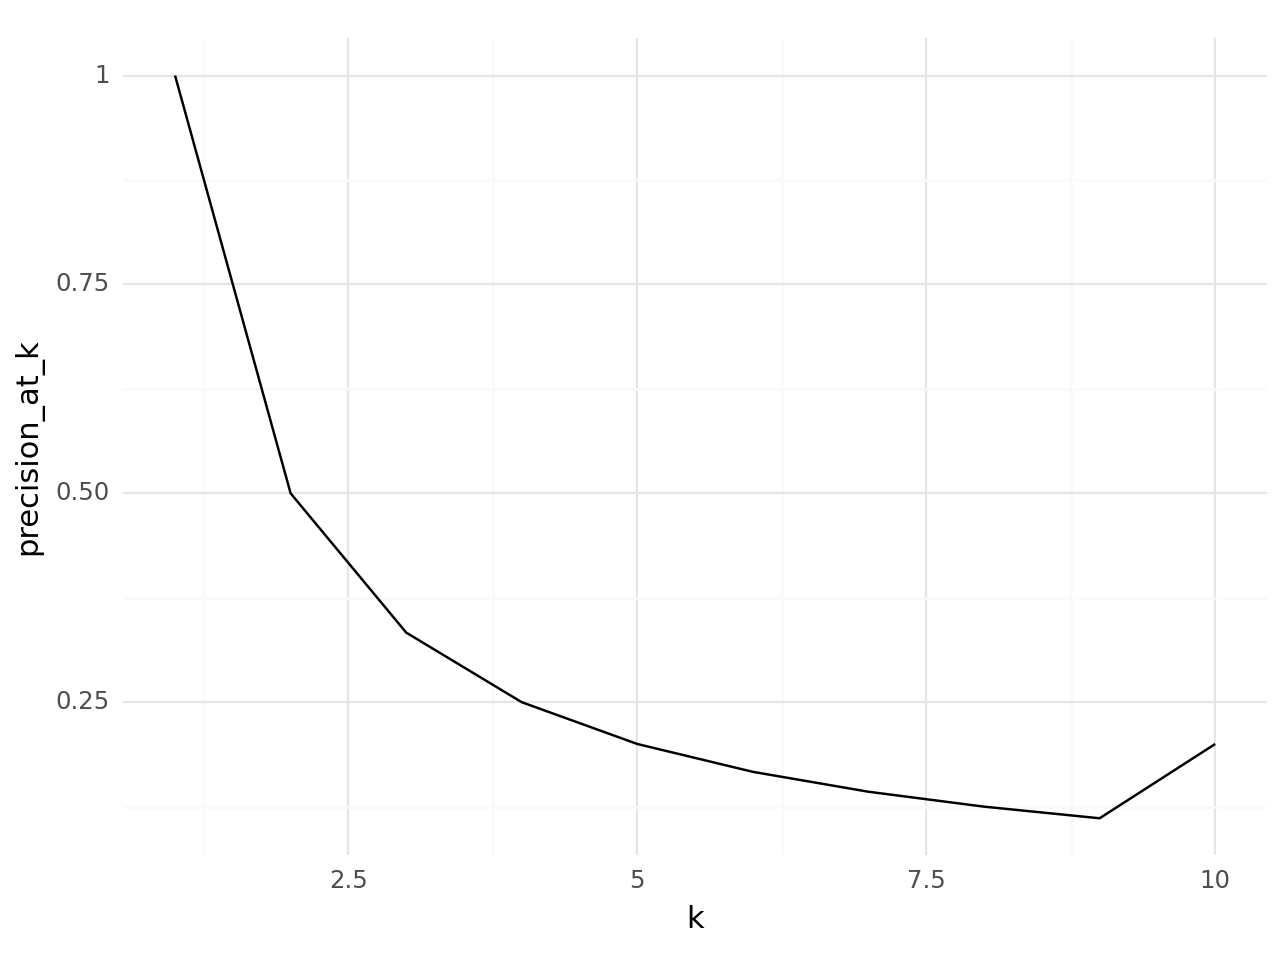

<Figure Size: (640 x 480)>

In [226]:
df_plot = pd.DataFrame({
    'k': [i for i in range(1,11)],
    'precision_at_k': [precision_at_k(outcome[5,:][None,:], user_item_prob[5,:][None,:], k=i) for i in range(1,11)]
    })
g = (ggplot(df_plot, aes(x='k',y='precision_at_k'))+
     geom_line())
g

AP@k คือค่าเฉลี่ยของ precision@k เมื่อ item ที่ k นั้นเป็น item ที่ถูกต้อง การที่ถ่วงน้ำหนักด้วยการที่ item k ถูกหรือไม่ถูกส่งผลให้ AP@k มีค่าสูงหาก item ที่ถูกต้องนั้นอยู่ลำดับบนๆ เนื่องจากโดยทั่วไปแล้ว precision@k จะลดลงเมื่อ k สูงขึ้น

In [227]:
#AP@10 ของ user_id==5
p_at_k=[]
for i in range(1,11):
    p_at_k.append(df_sorted[(df_sorted.user_id==5)&(df_sorted.rnk<i)].watched.mean())
p_at_k, len(p_at_k)

([1.0,
  0.5,
  0.3333333333333333,
  0.25,
  0.2,
  0.16666666666666666,
  0.14285714285714285,
  0.125,
  0.1111111111111111,
  0.2],
 10)

In [228]:
#item ที่ถูกต้องอยู่ที่ไหน
idx = np.where(df_sorted[(df_sorted.user_id==5)&(df_sorted.rnk<i)].watched==1)
idx

(array([0, 9]),)

In [229]:
#ค่าเฉลี่ยของ precision@k เฉพาะที่ outcome = 1 ของ user_id == 5
np.array(p_at_k)[idx], np.array(p_at_k)[idx].mean()

(array([1. , 0.2]), 0.6)

In [240]:
%%time
#คำนวณของทั้ง dataset ได้เหมือนกัน
#user-level mean of mean average precision
user_level_map = []
for u in range(df_sorted.user_id.nunique()):
    p_at_k = []
    for i in range(1,11):
        p_at_k.append(df_sorted[(df_sorted.user_id==u)&(df_sorted.rnk<i)].watched.mean())
    idx = np.where(df_sorted[(df_sorted.user_id==u)&(df_sorted.rnk<i)].watched==1)[0]
    if len(idx)>0:
        user_level_map.append(np.array(p_at_k)[idx].mean())
    else:
        user_level_map.append(0)

#ค่าเฉลี่ย mAP@10 ของ user 50 คน
len(user_level_map), np.mean(user_level_map)

CPU times: user 669 ms, sys: 4.27 ms, total: 673 ms
Wall time: 1.04 s


(50, 0.4019431216931217)

In [241]:
%%time

#เช่นเดิม รูปแบบแมททริคคำนวณได้เร็วกว่า


user_level_map = []
k=10
for u in range(user_item_prob.shape[0]):
    p_at_k = []
    for i in range(1,11):
        p_at_k.append(precision_at_k(outcome[u,:][None,:], user_item_prob[u,:][None,:], k=i))
    topk_preds = np.argsort(-user_item_prob[u,:][None,:], axis=1)[:, :k]
    topk_outcome = outcome[u,:][topk_preds]
    idx = np.where(topk_outcome[0]==1)[0]
    if len(idx)>0:
        user_level_map.append(np.array(p_at_k)[idx].mean())
    else:
        user_level_map.append(0)
len(user_level_map), np.mean(user_level_map)

CPU times: user 16.3 ms, sys: 0 ns, total: 16.3 ms
Wall time: 17.8 ms


(50, 0.3991693121693122)

In [242]:
#จะเห็นได้ว่าค่าเฉลี่ยต่างกันเล็กน้อยเกิดจากบาง item ที่มี predicted probability เท่ากัน
#ทำให้การเรียงลำดับของ np.argsort สุ่ม ต่างจากเวลาเรา sort dataframe ที่ควบคุมได้

u=29
i=10
df_sorted[(df_sorted.user_id==u)&(df_sorted.rnk<i)]

,user_id,anime_id,anime_name,predicted_probability,watched,rnk
586,29,6,My Hero Academia,0.970297,1.0,0
595,29,15,Code Geass,0.970297,0.0,1
589,29,9,Dragon Ball Z,0.891089,1.0,2
596,29,16,One Punch Man,0.891089,0.0,3
585,29,5,Sword Art Online,0.861386,0.0,4
599,29,19,Black Clover,0.792079,0.0,5
594,29,14,Demon Slayer: Kimetsu no Yaiba,0.782178,0.0,6
583,29,3,Death Note,0.762376,1.0,7
593,29,13,Fairy Tail,0.752475,1.0,8
588,29,8,Hunter x Hunter,0.722772,0.0,9


### Mean Reciprocal Rank (MRR)

เราจะเห็นได้ว่า AP และ mAP ให้ความสำคัญกับ **ลำดับของ item** ทางอ้อมด้วยการถ่วงค่าเฉลี่ย precision@k, mean reciprocal rank (MRR) ทำสิ่งนี้แบบตรงกว่า

MRR ของ user แต่ละคนคือ 1/ลำดับที่ item ที่ถูกต้องอันแรกถูกโมเดลแนะนำ

In [254]:
#reciprocal rank ของ user_id==3 คือ 1/8
df_sorted[df_sorted.user_id==3].head(10)

,user_id,anime_id,anime_name,predicted_probability,watched,rnk
77,3,17,Bleach,0.980198,0.0,0
74,3,14,Demon Slayer: Kimetsu no Yaiba,0.900990,0.0,1
73,3,13,Fairy Tail,0.811881,0.0,2
61,3,1,One Piece,0.782178,0.0,3
67,3,7,Tokyo Ghoul,0.643564,0.0,4
64,3,4,Fullmetal Alchemist: Brotherhood,0.574257,0.0,5
69,3,9,Dragon Ball Z,0.564356,0.0,6
78,3,18,The Promised Neverland,0.524752,1.0,7
72,3,12,Neon Genesis Evangelion,0.455446,0.0,8
63,3,3,Death Note,0.415842,0.0,9


In [255]:
#reciprocal rank ของ user_id==3 คือ 1/2
df_sorted[df_sorted.user_id==4].head(10)

,user_id,anime_id,anime_name,predicted_probability,watched,rnk
89,4,9,Dragon Ball Z,0.990099,0.0,0
94,4,14,Demon Slayer: Kimetsu no Yaiba,0.980198,1.0,1
99,4,19,Black Clover,0.841584,0.0,2
81,4,1,One Piece,0.831683,0.0,3
97,4,17,Bleach,0.782178,0.0,4
91,4,11,Steins;Gate,0.772277,1.0,5
88,4,8,Hunter x Hunter,0.752475,1.0,6
82,4,2,Naruto,0.742574,0.0,7
83,4,3,Death Note,0.673267,0.0,8
85,4,5,Sword Art Online,0.673267,0.0,9


In [259]:
#คำนวณจาก dataframe
(1/(df_sorted[df_sorted.watched==1].groupby('user_id').rnk.min()+1)).mean()

0.4919304388422035

In [243]:
def mean_reciprocal_rank(outcome, user_item_prob):
    reciprocal_ranks = []
    for i in range(len(outcome)):
        ranked_preds = np.argsort(-user_item_prob[i])
        first_correct_index = np.where(outcome[i][ranked_preds] == 1)[0]
        if len(first_correct_index) > 0:
            reciprocal_ranks.append(1.0 / (first_correct_index[0] + 1))
    mrr = np.mean(reciprocal_ranks)
    return mrr

In [261]:
#คำนวณจาก matrix
#จะเห็นได้ว่าค่าเฉลี่ยต่างกันเล็กน้อยเกิดจากบาง item ที่มี predicted probability เท่ากัน
#ทำให้การเรียงลำดับของ np.argsort สุ่ม ต่างจากเวลาเรา sort dataframe ที่ควบคุมได้

mean_reciprocal_rank(outcome, user_item_prob)

0.4819304388422035

## Regression

Regression เป็นงานทำนาย outcome ที่เป็นจำนวนจริงของแต่ละตัวอย่างจาก feature ที่ให้มา โดยทั่วไปแล้วเราควรจะรู้ว่า outcome ที่เป็นจำนวนจริงของเรานั้นมีการกระจายอย่างไร เช่น

1. Normal distribution กระจายตัวเป็นรูประฆังคว่ำรอบค่าเฉลี่ย มักพบในข้อมูลที่เก็บจากธรรมชาติ เช่น น้ำหนัก ส่วนสูง ฯลฯ หรือ

2. Power-law distribution ที่ตัวอย่างส่วนใหญ่กระจุกอยู่ระหว่างช่วงจำนวนใดจำนวนหนึ่ง มันพบในข้อมูลที่เกิดจากพฤติกรรมมนุษย์ เช่น ยอดขายของลูกค้าที่มักจะมีลูกค้าชั้นดีส่วนน้อยที่ใช้จ่ายเยอะและที่เหลือส่วนใหญ่เป็นลูกค้าที่ใช้จ่ายน้อย เป็นต้น

เพื่อให้เลือกใช้ metric ในการวัดผลได้อย่างเหมาะสม

In [264]:
np.random.seed(125)
num_samples = 300

# Power-law distribution parameters
alpha = 20.0  # Shape parameter
xmin = 1.0  # Minimum value

# Generate 'actual' values from a power-law distribution
actual_values = (np.random.pareto(alpha, num_samples) + 1) * xmin

# Generate 'pred' values with some noise
pred_values = actual_values + np.random.normal(0, 0.05, num_samples)  # Adding noise

# Create a DataFrame
df = pd.DataFrame({'actual': actual_values, 'pred': pred_values})
df

,actual,pred
0,1.035966,1.080678
1,1.002967,1.029749
2,1.050626,1.073544
3,1.007135,1.113163
4,1.007050,1.010675
...,...,...
295,1.112177,1.116984
296,1.033367,1.061958
297,1.045013,0.935497
298,1.058594,1.058634


เช่นเดียวกับการวัดผล classification สิ่งที่สำคัญที่สุดคือการพลอตข้อมูล `actual` และ `pred` ออกมาดูเพื่อให้เห็นการกระจายตัวจริงๆว่าใกล้เคียงกันแค่ไหน

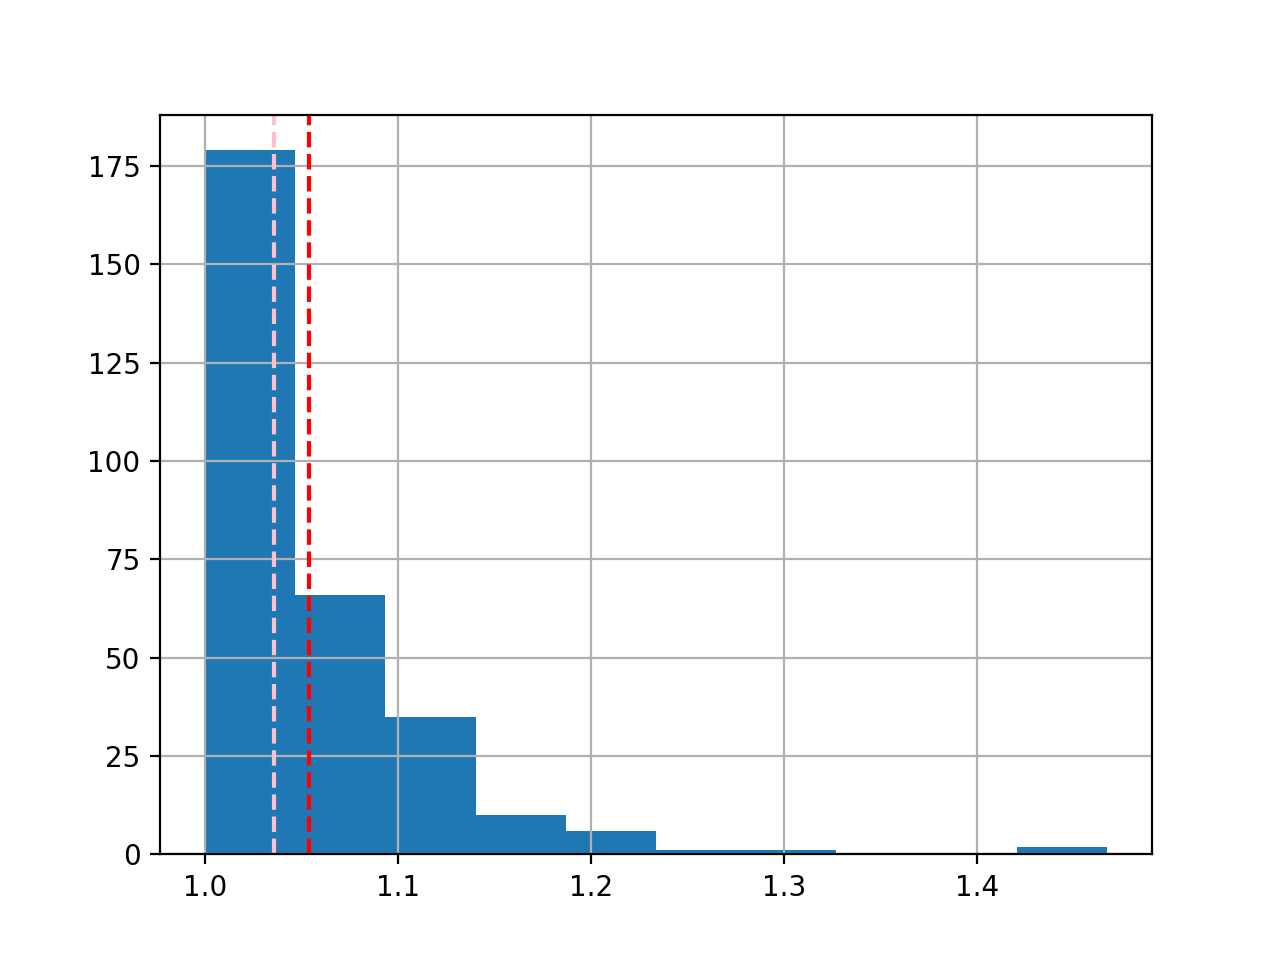

In [265]:
#ดูว่าค่าจริงกระจายตัวอย่างไร
#สีแดง mean; สีชมพู median
df.actual.hist()
plt.axvline(x=df.actual.mean(), color='red', linestyle='--', label='Mean')
plt.axvline(x=df.actual.median(), color='pink', linestyle='--', label='Median')

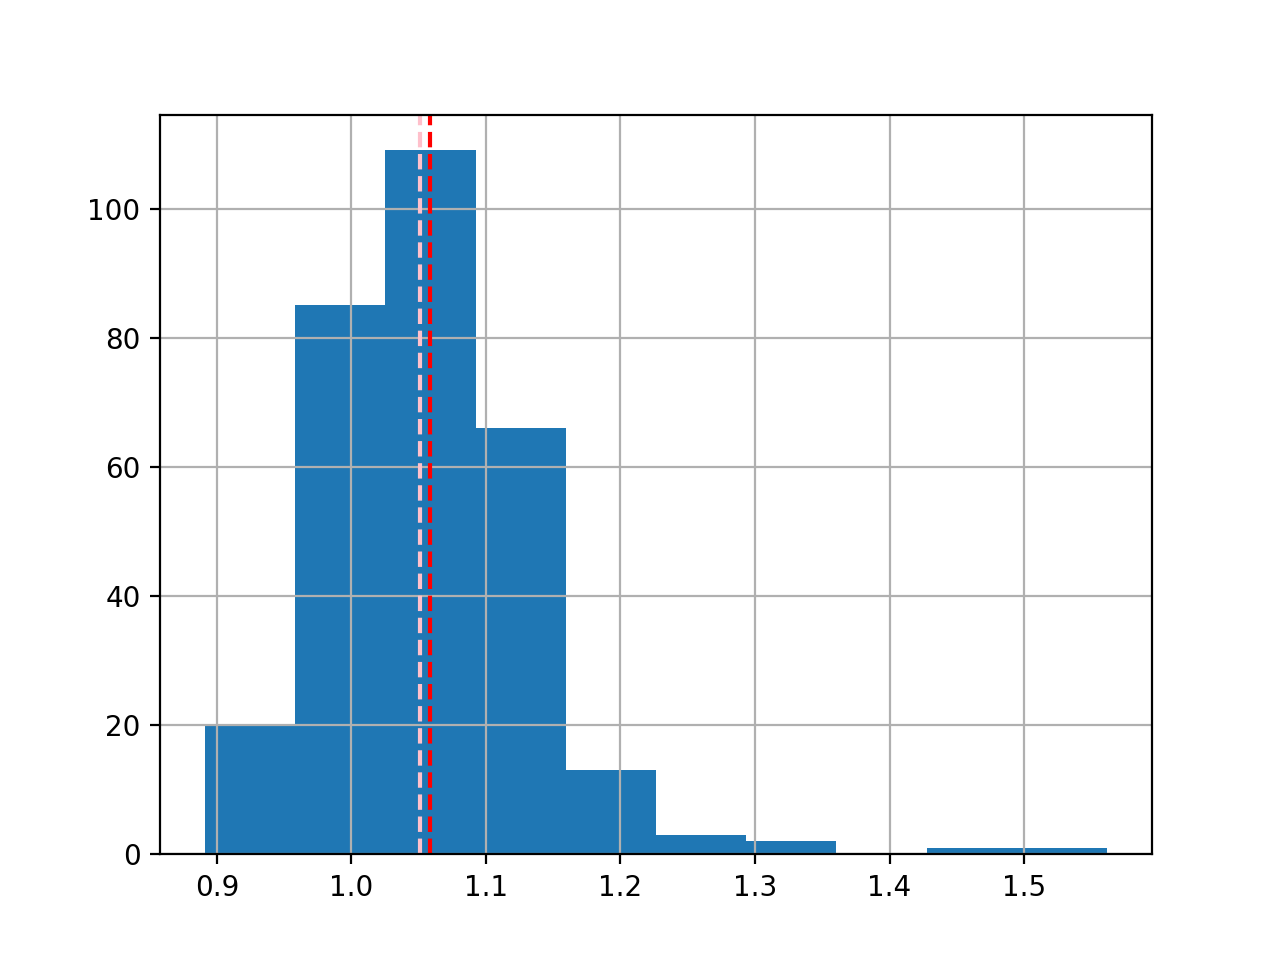

In [266]:
#ดูว่าค่าทำนายกระจายตัวอย่างไร
#สีแดง mean; สีชมพู median
df.pred.hist()
plt.axvline(x=df.pred.mean(), color='red', linestyle='--', label='Mean')
plt.axvline(x=df.pred.median(), color='pink', linestyle='--', label='Median')

<Axes: >

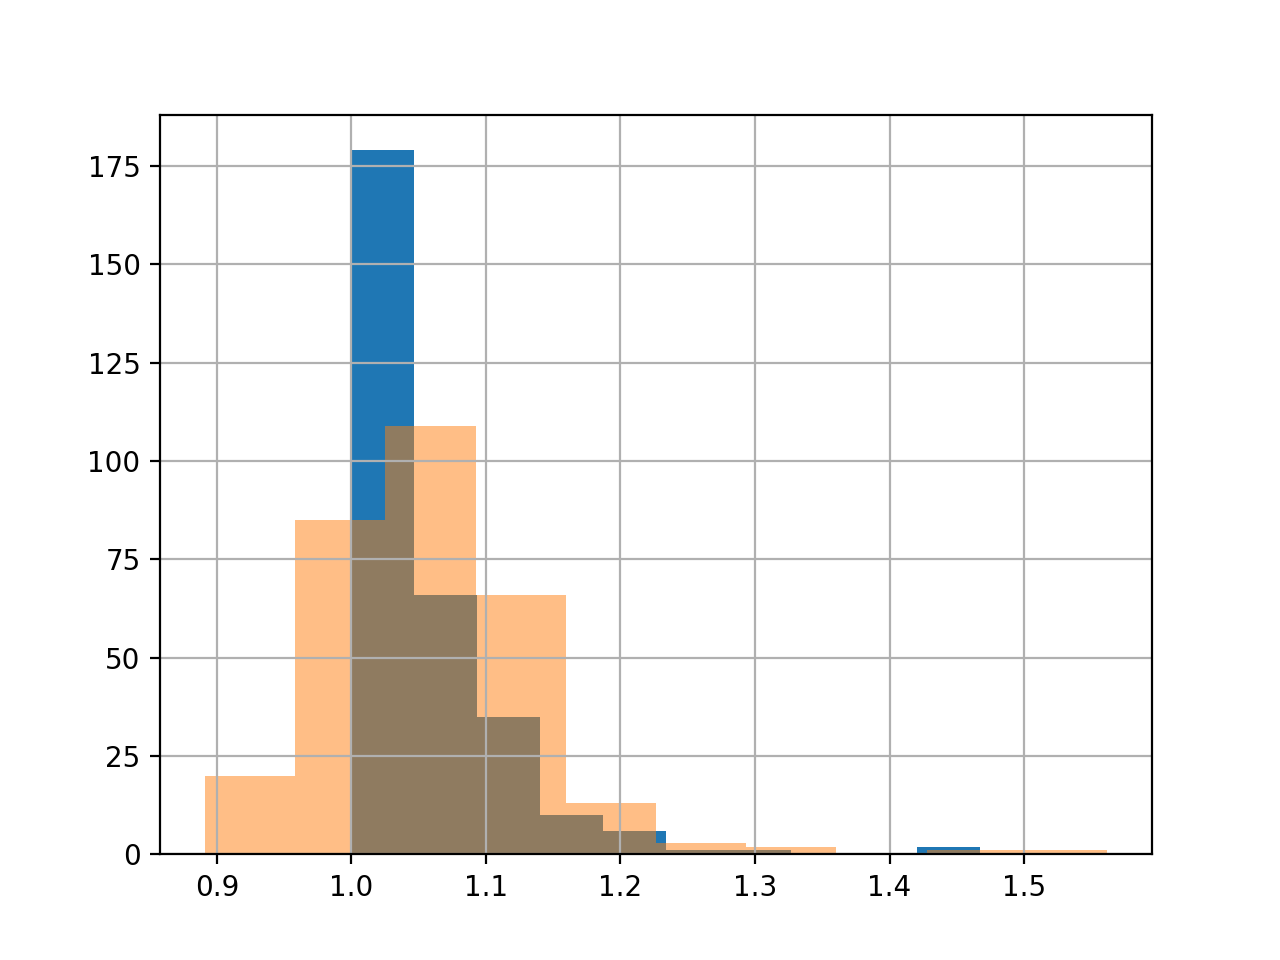

In [267]:
#เทียบการกระจายตัวของค่าจริงและค่าทำนาย
df.actual.hist()
df.pred.hist(alpha=0.5)

<Axes: xlabel='pred', ylabel='actual'>

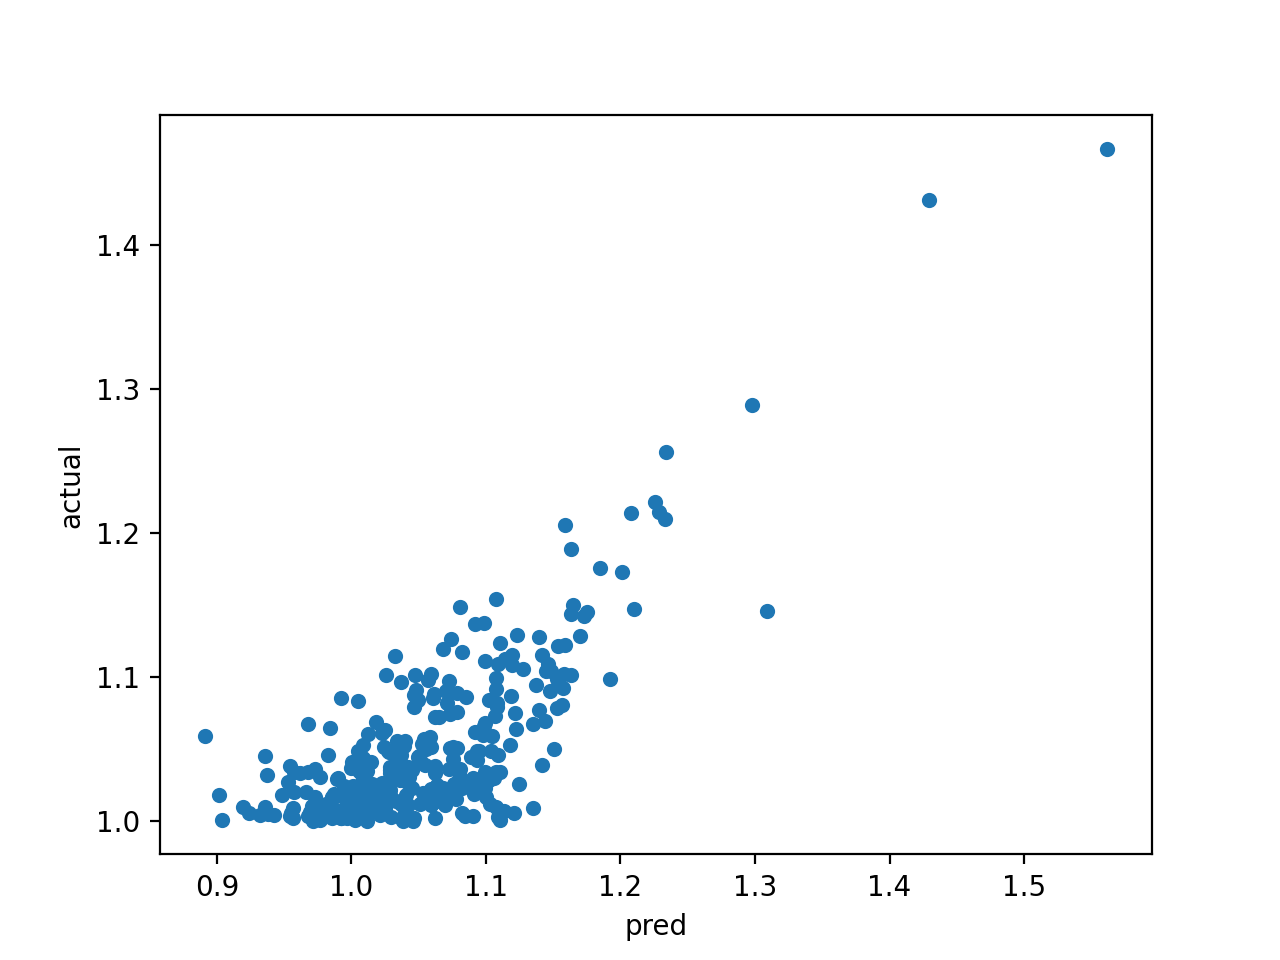

In [268]:
#scatter plot ค่าจริงและค่าทำนาย
df.plot.scatter(x='pred',y='actual')

เช่นเดียวกับ classification การที่เราจะบอกว่าโมเดลของเราทำได้ดีหรือไม่นั้นเราจำเป็นต้องมี baseline และ metric ที่ใช้เปรียบเทียบนอกจากการพลอตข้อมูลออกมาดู baseline ที่นิยมใช้ได้แก่

1. **โมเดลที่มีอยู่แล้ว**; แทบจะทุกปัญหาที่เราอยากแก้ (99.99%) จะมีคนที่พยามแก้มันอยู่แล้ว สิ่งแรกที่เราควรเปรียบเทียบกับโมเดลของเราจึงเป็นโมเดลที่ดีที่สุดในปัจจุบันที่คนอื่นทำไว้ หาได้ตาม [HuggingFace](https://huggingface.co/models), [Kaggle](https://www.kaggle.com/), [Google Scholar](https://scholar.google.com/), [Papers with Code](https://paperswithcode.com/) หรือ [Github](https://github.com/)

2. **กฎง่ายๆ**; เช่น เราอยากทำนายยอดขายของสินค้าในสัปดาห์หน้า สิ่งที่ง่ายที่สุดอาจจะเป็นยอดขายของสัปดาห์นี้ หรือสัปดาห์เดียวกันในปีที่แล้ว เป็นต้น

3. **ค่า mean, median หรือ mode**; ด้วยแนวคิดเดียวกับการดิ่งช้อยส์ของ classification เราอาจจะทำนายว่าทุกตัวอย่างมีค่าเท่ากับค่ากลางอันใดอันหนึ่ง

4. **เทียบกับมนุษย์**; baseline ที่น่าจะยากที่สุดสำหรับ ML model คือการเทียบว่ามันทำได้ดีแค่ไหนถ้าเทียบกับมนุษย์ เราอาจจะต้องไปเก็บข้อมูลแบบสอบถามให้มากพอที่จะน่าเชื่อถือ

ในบทเรียนนี้เราจะกล่าวถึง regression metric อันเป็นที่นิยมได้แก่

1. Mean Absolute Error (MAE); ค่าทำนายห่างจากความจริงแค่ไหนโดยเฉลี่ย

2. Mean Squared Error (MSE); ความต่างระหว่างค่าทำนายกับความจริงยกกำลังสองเฉลี่ยเป็นเท่าไหร่ ต่างจาก 1. เนื่องจากยิ่งค่าทำนายต่างจากความจริงมากเท่าไหร่ MSE ก็จะยิ่งสูงขึ้นเป็นทวีคูณ

In [269]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

df['pred_mean'] = df.actual.mean()
df['pred_median'] = df.actual.median()


print(f'''
Model
MAE: {mean_squared_error(y_true=df.actual, y_pred=df.pred)}
MSE: {mean_squared_error(y_true=df.actual, y_pred=df.pred)}

Baseline ทำนาย mean
MAE: {mean_squared_error(y_true=df.actual, y_pred=df.pred_mean)}
MSE: {mean_squared_error(y_true=df.actual, y_pred=df.pred_mean)}

Baseline ทำนาย median
MAE: {mean_squared_error(y_true=df.actual, y_pred=df.pred_median)}
MSE: {mean_squared_error(y_true=df.actual, y_pred=df.pred_median)}
''')


Model
MAE: 0.0023770323405596194
MSE: 0.0023770323405596194

Baseline ทำนาย mean
MAE: 0.0034561148657859717
MSE: 0.0034561148657859717

Baseline ทำนาย median
MAE: 0.0037863569402629012
MSE: 0.0037863569402629012



มีหนึ่ง metric ที่บางครั้งถูกใช้งานคือ mean absolute percentage error (MAPE) วิธีคำนวณตามฟังก์ชันด้านล่าง ข้อดีคือแสดงผลเป็น % ทำให้ไม่ต้องกังวลถึงหน่วยของ outcome

แต่ metric นี้มีข้อเสียอย่างใหญ่หลวงอยู่คือ

1. การใช้ค่าที่แท้จริง (`actual`) เป็นตัวหารอาจทำให้ MAPE มีค่าไม่เสถียรในกรณีที่ `actual` ใกล้ 0 มาก (อาจจะเห็น MAPE 1,000%) หรือเป็น 0 (คำนวณไม่ได้แต่แรก)

2. ในกรณีทำนายจำนวนบวก การใช้ค่าที่แท้จริง (`actual`) เป็นตัวหารทำให้การทำนายสูงเกินไปมีความเสี่ยงกว่าการทำนายต่ำไป เนื่องจากต่อให้เราทำนายต่ำที่สุดเท่าที่จะทำได้ (ทำนาย 0) MAPE ก็จะสูงสุดได้แค่ 100% แต่หากทำนายสูงไป MAPE จะสูงเท่าไหร่ก็ได้

โดยทั่วไปแล้ว เราจึงไม่แนะนำให้ใช้งาน metric ในการรายงานผล

In [276]:
def mean_absolute_percentage_error(y_true,y_pred):
    return abs((y_true-y_pred)/y_true).mean()*100

y_true = np.array([0.1,0.1,0.1])
y_pred_high = np.array([4,4,4])
y_pred_low = np.array([0,0,0])


mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred_high), \
mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred_low)

(3900.0, 100.0)

## Choose Metrics That Most Directly Lead to Actions

* แบ่ง train-valid-test เพื่อให้มีข้อมูลเพียงพอและทดสอบประสิทธิผลของโมเดลได้อย่างยุติธรรม
* พลอตข้อมูลออกมาดูก่อนเสมอ ไม่ว่าจะเป็น confusion matrix หรือการกระจายตัวของคำทำนาย
* เริ่มคิดจากปัญหาก่อน เราทำโมเดลไปเพื่อแก้ปัญหาอะไร แล้วปัญหานั้นต้องการตัววัดผลแบบไหน เช่น หากต้องการทำนายตัวอย่าง positive ให้มากที่สุดเท่าที่จะทำได้โดยไม่กลัว false positive มากนัก ก็เน้น recall, หากต้องการให้คำทำนายส่วนใหญ่ถูกก็เน้น precision หรือจะสร้าง metric ขึ้นมาใช้เองก็ยังได้

## คำถามชวนคิดเกี่ยวกับบทเรียน

1. ทำไม f-score ต้องคำนวนด้วย [harmonic mean ไม่ใช่ arithmetic mean](https://stackoverflow.com/questions/26355942/why-is-the-f-measure-a-harmonic-mean-and-not-an-arithmetic-mean-of-the-precision)?
2. เนื่องจาก AUROC เปรียบเทียบโมเดลโดยไม่คำนึงถึง cutoff ทำให้มันดีกว่า accuracy, precision, recall, f-score ในทุกกรณี จริงหรือไม่? เพราะอะไร?
3. mAP กับ AUPRC เกี่ยวข้องกันอย่าไร?
4. ถ้า MAE ของโมเดลเราดีกว่า baseline แต่ MSE แย่กว่า เราจะตัดสินใจว่าโมเดลเราดีหรือไม่อย่างไร?


## สิ่งที่ควรเตรียมพร้อมสำหรับทำโครงงาน

### ☑️ ทบทวนระบบการให้คะแนนโครงงานให้เรียบร้อย

AI Builders จะออกใบประกาศนียบัตรจบการศึกษาให้กับผู้เข้าร่วมโครงการที่ส่งโครงงานได้คะแนนอย่างน้อย 70 จาก 100 คะแนนตามเกณฑ์ต่อไปนี้เท่านั้น

1. problem statement; เหตุผลในการแก้ปัญหาเชิงธุรกิจ/ชีวิตประจำวันด้วย machine learning - 15 คะแนน
2. metrics and baselines; การให้เหตุผลเชื่อมโยงการแก้ปัญหากับตัวชี้วัดที่เลือก / การวัดผลเทียบกับวิธีแก้ปัญหาในปัจจุบัน - 15 คะแนน
3. data collection and cleaning; การเก็บและทำความสะอาดข้อมูล - 15 คะแนน

**วันนี้เราจะคิดถึง 2 ข้อนี้เป็นพิเศษ**

**4. exploratory data analysis; การทำความเข้าใจข้อมูล - 20 คะแนน**

**5. modeling, validation and error analysis; การทำโมเดล, ทดสอบโมเดล และวิเคราะห์ข้อผิดพลาดของโมเดล - 20 คะแนน**

6. deployment; การนำโมเดลไปใช้แก้ปัญหาจริง - 15 คะแนน

### ☑️ เข้าใจชุดข้อมูล

คุณรู้เกี่ยวกับ labels ที่คุณกำลังทำนายแค่ไหน
* ถ้าเป็น classification มันมี labels กี่ประเภท (class) แต่ละตัวอย่างเป็นได้มากกว่าหนึ่งประเภท (multi-label) หรือได้แค่ประเภทเดียว (multi-class)
* ถ้าเป็น regression แล้ว labels ของคุณกระจายตัวยังไง
* คุณมีตัวอย่างพอในแต่ละ class ให้โมเดลเรียนรู้หรือเปล่า

features ของคุณหน้าตาเป็นอย่างไร

* ถ้าเป็นรูปภาพ เป็นรูปจากมุมมองเดียวหรือหลายมุมมอง ขนาดรูป-ความละเอียดเท่ากันไหม
* ถ้าเป็นข้อความ การกระจายตัวของคำเป็นยังไง ทั้ง word count และ tfidf; คำที่เกิดบ่อยๆในแต่ละ labels คืออะไร
* ถ้าเป็นข้อมูลตาราง การกระจายตัวของ feature ที่เป็นตัวเลข (numerical) และประเภท (categorical) เป็นอย่างไรบ้าง ลองหา correlation ระหว่าง features ด้วยกัน และ feature กับ labels ดูว่ามีอะไรน่าสนใจไหม



### ☑️ เทรนโมเดลแรกให้จบจนเห็นผลลัพธ์เร็วที่สุดเท่าที่จะทำได้

แน่นอนว่าการทำความสะอาดข้อมูลและการทำความเข้าใจข้อมูลเป็นสิ่งสำคัญ (คะแนนรวม 15+20=35) แต่วิธีที่ดีที่สุดที่จะรู้ว่าโมเดลของเราทำได้ดีแค่ไหนคือการลองเทรนไปเลยทั้งๆที่ไม่ต้องทำอะไรกับข้อมูลมาก หลังจากนั้นเราอาจจะมาไล่ดูข้อผิดพลาดของโมเดลเพื่อให้มีไอเดียในการจัดการข้อมูลและโมเดลต่อไปได้

คุณอาจจะคิดว่าการสร้าง ML model มีขั้นตอนแบบนี้:

<img src=https://github.com/ai-builders/curriculum/raw/main/images/ml_what_you_think_it_is.png width="500px">

แต่จริงๆแล้วมันคือแบบนี้:

<img src=https://github.com/ai-builders/curriculum/raw/main/images/ml_what_it_really_is.png width="500px">

เพราะฉะนั้นอย่ากลัวที่จะลองทำให้ครบขั้นตอนก่อนแล้วจึงย้อนกลับไปกลับมาเพื่อทำใหม่ให้ดียิ่งขึ้น